# 1. Thư viện

In [2]:
import math
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from scipy import stats
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from scipy.stats import norm, multivariate_normal
from pandas.errors import SettingWithCopyWarning
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_curve, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

from sklearn.decomposition import PCA

import itertools
from scipy import linalg
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
import networkx as nx
from sklearn.metrics import davies_bouldin_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

os.makedirs("image/", exist_ok=True)

# 2. Dữ liệu

## 2.1. Đọc file dữ liệu

`application_record.csv` là thông tin người nộp đơn

`credit_record.csv` là lịch sử tính dụng

In [ ]:
cc_data_full_data = pd.read_csv('https://raw.githubusercontent.com/ankkun13/machine-learning-final-exam-25_26/refs/heads/main/datasets/raw/application_record.csv')
credit_status = pd.read_csv('https://raw.githubusercontent.com/ankkun13/machine-learning-final-exam-25_26/refs/heads/main/datasets/raw/credit_record.csv')

In [ ]:
cc_data_full_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

In [ ]:
credit_status.head()

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

## 2.2. Tạo target variable

Hai tệp này được kết hợp và xử lý để tạo ra biến mục tiêu `Is_high_risk` (Có rủi ro cao không). Biến này xác định xem một khách hàng có từng quá hạn thanh toán trên 60 ngày hay không, là yếu tố cốt lõi để mô hình dự đoán.

In [ ]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is_high_risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is_high_risk']=='Yes','Is_high_risk']=1
cc_data_full_data.loc[cc_data_full_data['Is_high_risk']=='No','Is_high_risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

/tmp/ipython-input-1638824809.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
/tmp/ipython-input-1638824809.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step 

## 2.3. Đổi tên thuôc tính

Đổi tên các cột trong bộ dữ liệu để dễ đọc và dễ hiểu hơn

In [ ]:
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender', # Giới tính
    'FLAG_OWN_CAR':'Has_a_Car', # Có xe hơi
    'FLAG_OWN_REALTY':'Has_a_Property', # Có bất động sản
    'CNT_CHILDREN':'Children_Count', # Số lượng con cái
    'AMT_INCOME_TOTAL':'Income', # Tổng thu nhập
    'NAME_INCOME_TYPE':'Employment_Status', # Tình trạng việc làm
    'NAME_EDUCATION_TYPE':'Education_Level', # Trình độ học vấn
    'NAME_FAMILY_STATUS':'Marital_Status', # Tình trạng hôn nhân
    'NAME_HOUSING_TYPE':'Dwelling', # Loại hình nhà ở
    'DAYS_BIRTH':'Age', # Tuổi
    'DAYS_EMPLOYED': 'Employment_Length', # Thời gian làm việc
    'FLAG_MOBIL': 'Has_a_Mobile_Phone', # Có điện thoại di động
    'FLAG_WORK_PHONE': 'Has_a_Work_Phone', # Có điện thoại bàn
    'FLAG_PHONE': 'Has_a_Phone', # Có điện thoại
    'FLAG_EMAIL': 'Has_an_Email', # Có email
    'OCCUPATION_TYPE': 'Job_Title', # Chức vụ
    'CNT_FAM_MEMBERS': 'Family_Member_Count', # Số lượng thành viên gia đình
    'Account age': 'Account_Age' # Tuổi tài khoản
    })

# 2. Tổng quan và trực quan hóa dữ liệu

## 2.1. Tổng quan

Cung cấp một cái nhìn tổng quan về dữ liệu bằng các lệnh như `head()`, `info()`, `describe()`. Phần này cũng sử dụng biểu đồ ma trận để trực quan hóa các giá trị bị thiếu trong cột `Job_Title`.

In [ ]:
cc_data_full_data.head()

ID Gender Has_a_Car Has_a_Property  Children_Count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment_Status                Education_Level        Marital_Status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment_Length  Has_a_Mobile_Phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has_a_Work_Phone  Has_a_Phone  Has_an_Email       Job_Title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family_Member_Count  Account_Age Is_high_risk  
0                  2.0        -15.0            0  
1                  2.0        -14.0            0  
2                  2.0        -29.0            0  
3                  1.0         -4.0            0  
4                  1.0        -26.0            0

In [ ]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has_a_Car            36457 non-null  object 
 3   Has_a_Property       36457 non-null  object 
 4   Children_Count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment_Status    36457 non-null  object 
 7   Education_Level      36457 non-null  object 
 8   Marital_Status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment_Length    36457 non-null  int64  
 12  Has_a_Mobile_Phone   36457 non-null  int64  
 13  Has_a_Work_Phone     36457 non-null  int64  
 14  Has_a_Phone          36457 non-null  int64  
 15  Has_an_Email         36457 non-null 

## 2.2. Chuẩn hóa dữ liệu

1. `Account age` (Tuổi tài khoản)

**Lý do chính**: Rò rỉ dữ liệu (Data Leakage).

**Giải thích**: Đây là lý do quan trọng nhất. Trong Phần 1.1 của notebook, cột MONTHS_BALANCE (là nguồn gốc của Account age) được sử dụng để tạo ra biến mục tiêu Is high risk. Cụ thể, logic là "nếu một khách hàng có bất kỳ tháng nào quá hạn (giá trị < -60) thì họ là 'rủi ro cao'".

Nếu giữ lại cột Account age để dự đoán Is high risk, mô hình sẽ "gian lận". Nó sẽ học được một quy tắc gần như tuyệt đối (ví dụ: "nếu Account age < -60 thì 100% là rủi ro cao"), dẫn đến điểm số chính xác ảo trên tập huấn luyện, nhưng sẽ hoàn toàn thất bại khi dự đoán dữ liệu thực tế (vì lúc đó bạn chưa biết lịch sử tài khoản của họ).

2. `Job title` (Chức danh công việc)

**Lý do chính**: Quá nhiều giá trị bị thiếu (Missing Values).

**Giải thích**: Khoảng 30.5% số hàng không có thông tin về chức danh.

Việc cố gắng điền (impute) một lượng lớn dữ liệu bị thiếu như vậy có thể tạo ra nhiều "nhiễu" (noise) hơn là tín hiệu hữu ích, làm giảm chất lượng của mô hình. Do đó, quyết định an toàn và phổ biến là loại bỏ nó.

3. `Has a mobile phone` (Có điện thoại di động)

**Lý do chính**: Giá trị không đổi (Constant Value) / Phương sai bằng 0.

**Giải thích**: 100% ứng viên trong tập dữ liệu đều có điện thoại di động (giá trị = 1).

Một đặc trưng mà tất cả mọi người đều có cùng một giá trị sẽ không cung cấp bất kỳ thông tin hữu ích nào cho mô hình. Mô hình không thể học được bất kỳ sự khác biệt nào từ một cột không có sự thay đổi (không có phương sai).

4. `Children count` (Số lượng con cái)

**Lý do chính**: Sức mạnh dự đoán thấp (Low Predictive Power).

**Giải thích**: Trong phân tích đa biến (ví dụ: Phần 2.4.3), khi so sánh cột Children count với biến mục tiêu Is high risk, không có sự khác biệt rõ rệt hoặc xu hướng (pattern) đáng kể nào về rủi ro tín dụng giữa các nhóm có số lượng con cái khác nhau.

Vì đặc trưng này dường như không giúp ích cho việc phân biệt giữa nhóm rủi ro cao và nhóm rủi ro thấp, nó đã bị loại bỏ để làm cho mô hình đơn giản hơn và tập trung vào các đặc trưng có ảnh hưởng rõ rệt hơn.

### Bỏ cột không cần thiết

In [ ]:
columns_to_drop = ['ID', 'Account_Age', "Job_Title", "Has_a_Mobile_Phone", "Children_Count"]
data = cc_data_full_data.drop(columns = columns_to_drop)

### Xử lý Outliner

In [ ]:
feat_with_outliers = ['Family_Member_Count','Income', 'Employment_Length']
if (set(feat_with_outliers).issubset(data.columns)):
    # 25% quantile
    Q1 = data[feat_with_outliers].quantile(.25)
    # 75% quantile
    Q3 = data[feat_with_outliers].quantile(.75)
    IQR = Q3 - Q1
    # keep the data within 3 IQR
    data = data[~((data[feat_with_outliers] < (Q1 - 3 * IQR)) |(data[feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]

### Xử lý giá trị ngày và giá trị nghỉ hưu

In [ ]:
#Employment_Length và Age là các giá trị âm, chuyển về dương
data[['Employment_Length','Age']] = np.abs(data[['Employment_Length','Age']])

#Employment_Length có giá trị 365243 (Nghỉ hưu), thay thế giá trị này bằng 0 của cột
data.loc[data['Employment_Length'] == 365243, 'Employment_Length'] = 0

#Age được tính bằng ngày, chuyển đổi sang năm
data['Age'] = (data['Age'] / 365.25)

#Employment_Length chuyển sang năm
data['Employment_Length'] = (data['Employment_Length'] / 365.25)


### Skewness

In [ ]:
feat_with_skewness=['Income','Age']
if (set(feat_with_skewness).issubset(data.columns)):
    # Handle skewness with cubic root transformation
    data[feat_with_skewness] = np.cbrt(data[feat_with_skewness])

### Chuẩn hóa trường dữ liệu về [0,1]

In [ ]:
# Danh sách các nhóm cột (Bạn hãy kiểm tra lại tên cột chính xác trong data của mình)
numeric_features = ['Income', 'Age', 'Employment_Length', 'Family_Member_Count']
binary_features = ['Gender', 'Has_a_Car', 'Has_a_Property', 'Has_a_Work_Phone','Has_a_Phone','Has_an_Email'] # Biến nhị phân
nominal_features = ['Marital_Status', 'Dwelling', 'Employment_Status'] # Biến không thứ tự
ordinal_features = ['Education_Level'] # Biến có thứ tự

# Định nghĩa thứ tự cho trình độ học vấn
edu_order = [
    'Lower secondary',
    'Secondary / secondary special',
    'Incomplete higher',
    'Higher education',
    'Academic degree'
]

# Pipeline chuẩn hóa dữ liệu
preprocessor = ColumnTransformer(
    transformers=[
        # Chuẩn hóa biến số về khoảng [0, 1]
        ('num', MinMaxScaler(), numeric_features),

        # Mã hóa nhị phân (chuyển thành 1 cột 0/1)
        ('bin', OneHotEncoder(drop='if_binary'), binary_features),

        # Mã hóa One-Hot cho các biến phân loại không thứ tự
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_features),

        # Mã hóa Ordinal cho biến có thứ tự (Education)
        ('ord', OrdinalEncoder(categories=[edu_order]), ordinal_features)
    ])



In [ ]:
X_test = data.drop('Is_high_risk', axis=1)
y_test = data['Is_high_risk']
X_test = preprocessor.fit_transform(X_test)

print(X_test)
print(X_test.shape)


[[0.88925082 0.34996471 0.39991162 ... 0.         1.         3.        ]
 [0.88925082 0.34996471 0.39991162 ... 0.         1.         3.        ]
 [0.35848046 0.86428073 0.09871852 ... 0.         1.         1.        ]
 ...
 [0.47087584 0.37520213 0.11559876 ... 0.         0.         3.        ]
 [0.70016625 0.69539828 0.05638533 ... 0.         1.         1.        ]
 [0.35848046 0.14490377 0.10393283 ... 0.         1.         1.        ]]
(29579, 27)


### Một số hàm cần thiết cho huấn luyện

In [ ]:
def data_split(df, test_size):
    df["Is_high_risk"] = pd.to_numeric(df["Is_high_risk"])
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

    X_train = train_df.drop('Is_high_risk', axis=1)
    y_train = train_df['Is_high_risk']
    X_test = test_df.drop('Is_high_risk', axis=1)
    y_test = test_df['Is_high_risk']
    return X_train.reset_index(drop=True), y_train.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

def SMOTE_oversample(X, y):
    oversample = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = oversample.fit_resample(X, y)

    return X_resampled, y_resampled

def RandomSampler(X, y):
  oversample = RandomOverSampler(sampling_strategy='minority')
  X_resampled, y_resampled = oversample.fit_resample(X, y)

  return X_resampled, y_resampled

## 2.3. Thống kê sơ bộ dữ liệu

In [ ]:
print("Kích thước dữ liệu:",data.shape)
print(data.describe())

Kích thước dữ liệu: (29579, 15)
             Income           Age  Employment_Length  Has_a_Work_Phone  \
count  29579.000000  29579.000000       29579.000000      29579.000000   
mean      56.005893      3.407985           6.977781          0.271375   
std        8.181643      0.270758           5.902512          0.444677   
min       30.000000      2.737019           0.046543          0.000000   
25%       51.299278      3.193345           2.631075          0.000000   
50%       55.504991      3.410955           5.360712          0.000000   
75%       60.822020      3.623360           9.453799          1.000000   
max       80.977589      4.069237          31.025325          1.000000   

        Has_a_Phone  Has_an_Email  Family_Member_Count  
count  29579.000000  29579.000000         29579.000000  
mean       0.292877      0.099361             2.288989  
std        0.455090      0.299151             0.920457  
min        0.000000      0.000000             1.000000  
25%        0.000

## 2.4. PCA

In [ ]:
# Drop Is_high_risk
X_pca = data.drop('Is_high_risk', axis=1)

# Apply preprocessing to X
X_pca = preprocessor.fit_transform(X_pca) # Fit and transform the preprocessor for PCA

y_pca = data['Is_high_risk'].values # y remains the same

cov_matrix = np.cov(X_pca.T) # Use the processed numerical data

# Tính gia trị riêng và vector riêng
eig_values, eig_vectors = np.linalg.eig(cov_matrix)
# Sắp xếp giá trị riêng giảm dần
idx = np.argsort(eig_values)[::-1]
eig_values = eig_values[idx]
eig_vectors = eig_vectors[:, idx]
# Tính explained variance
explained_variance = (eig_values / np.sum(eig_values)) * 100
cumulative_variance = np.cumsum(explained_variance)

# Lấy phần thực
explained_variance_real = np.real(explained_variance)
cumulative_variance_real = np.real(cumulative_variance)
eig_vectors_real = np.real(eig_vectors)
n_components_opt = np.argmax(cumulative_variance_real >= 90) + 1
print('Số thành phần chính cần để giữ 90% phương sai:', n_components_opt)

Số thành phần chính cần để giữ 90% phương sai: 12


In [ ]:
n_components_viz = 12
components_data = {}
for i in range(n_components_viz):
    components_data[f'PC{i+1}'] = X_pca.dot(eig_vectors_real[:, i])

# Tạo DataFrame cho PCA
pca_df = pd.DataFrame(components_data)
pca_df['Is_high_risk'] = y_pca
pca_df['Risk_Label'] = pca_df['Is_high_risk'].map({0: 'Low Risk', 1: 'High Risk'})

   1. PC1 vs PC2
   2. PC1 vs PC3
   3. PC1 vs PC4
   4. PC1 vs PC5
   5. PC1 vs PC6
   6. PC2 vs PC3
   7. PC2 vs PC4
   8. PC2 vs PC5
   9. PC2 vs PC6
  10. PC3 vs PC4
  11. PC3 vs PC5
  12. PC3 vs PC6
  13. PC4 vs PC5
  14. PC4 vs PC6
  15. PC5 vs PC6


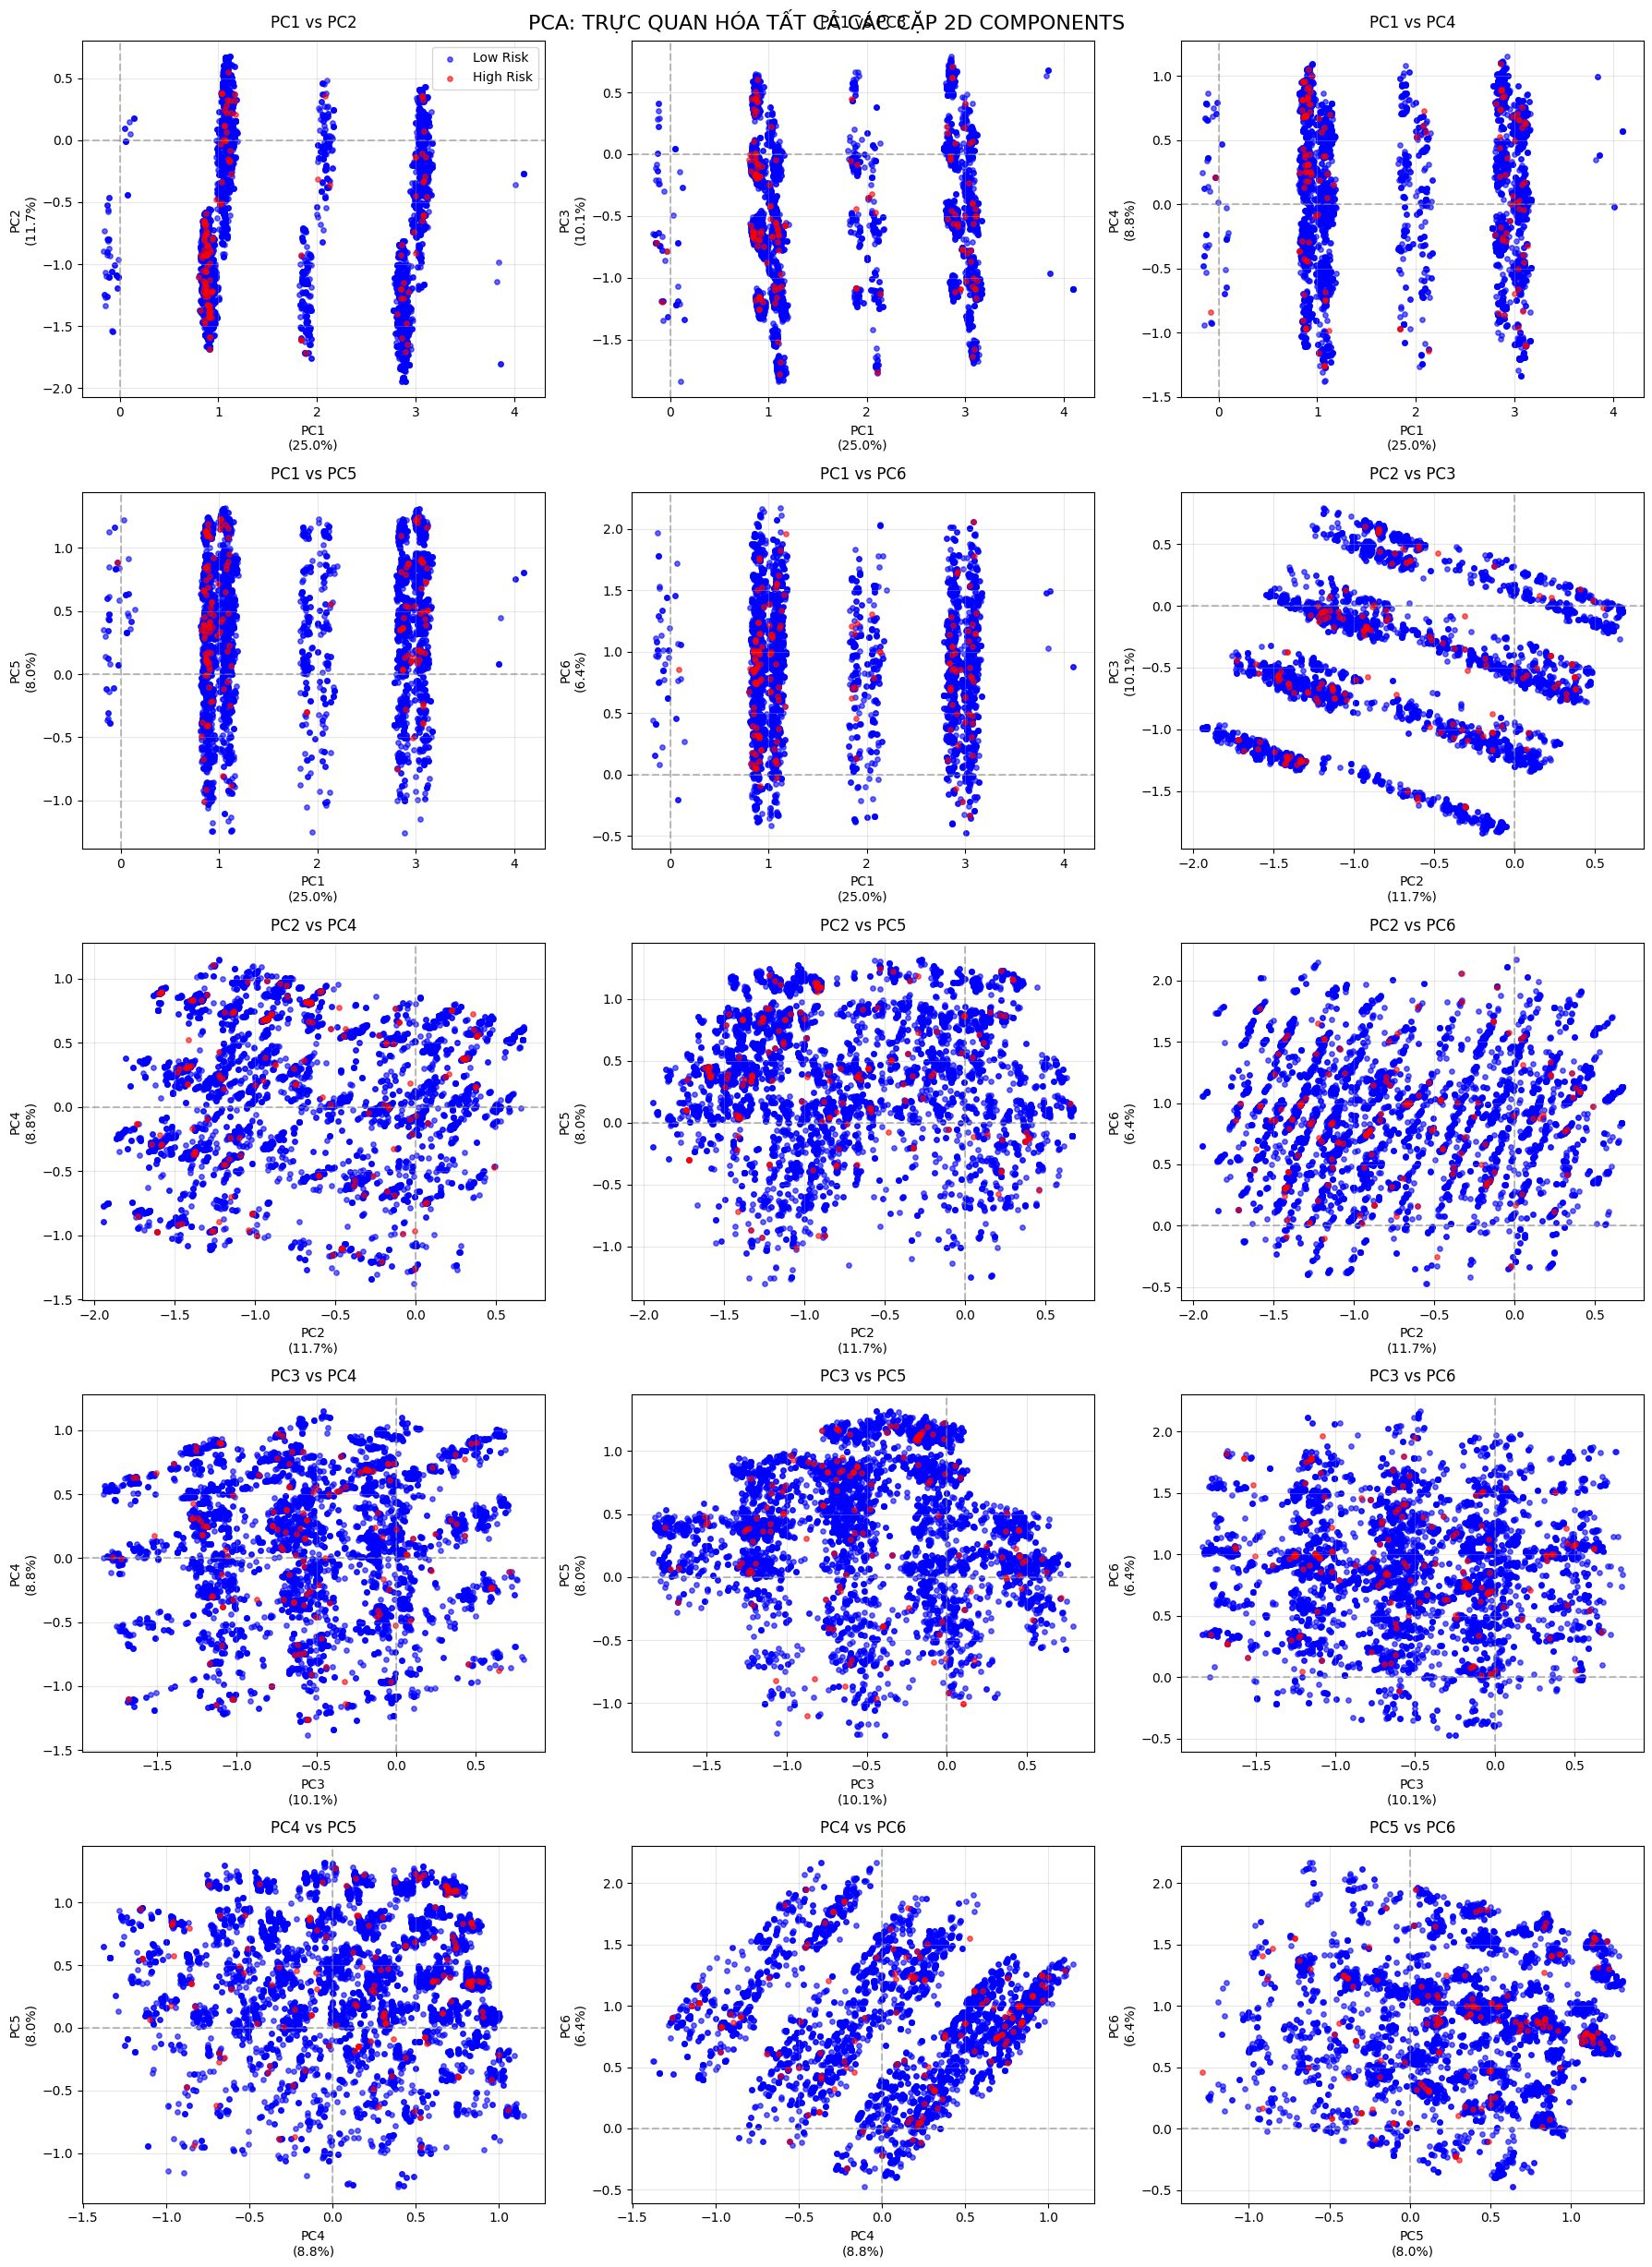

In [ ]:
def plot_all_2d_pairs(pca_df, n_components=6):
    n_pairs = n_components * (n_components - 1) // 2
    n_cols = 3
    n_rows = (n_pairs + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    if n_rows > 1:
        axes = axes.flatten()
    elif n_cols == 1:
        axes = [axes]
    else:
        axes = axes
    pairs = []
    for i in range(n_components):
        for j in range(i+1, n_components):
            pairs.append((i, j))
    for idx, (i, j) in enumerate(pairs, 1):
        pc_i = f'PC{i+1}'
        pc_j = f'PC{j+1}'
        print(f"  {idx:2d}. {pc_i} vs {pc_j}")

    for idx, (i, j) in enumerate(pairs):
        ax = axes[idx]

        pc_i = f'PC{i+1}'
        pc_j = f'PC{j+1}'
        for risk_level, color, label in [(0, 'blue', 'Low Risk'), (1, 'red', 'High Risk')]:
            mask = (pca_df['Is_high_risk'] == risk_level)
            sample_mask = mask & (np.random.random(len(pca_df)) < 0.3)
            ax.scatter(pca_df.loc[sample_mask, pc_i], pca_df.loc[sample_mask, pc_j],
                      c=color, label=label, alpha=0.6, s=15)
        ax.set_xlabel(f'{pc_i}\n({explained_variance_real[i]:.1f}%)', fontsize=10)
        ax.set_ylabel(f'{pc_j}\n({explained_variance_real[j]:.1f}%)', fontsize=10)
        ax.set_title(f'{pc_i} vs {pc_j}', fontsize=12, pad=10)
        ax.axhline(y=0, color='grey', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)

        if idx == 0:
            ax.legend()
    for idx in range(len(pairs), len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('PCA: TRỰC QUAN HÓA TẤT CẢ CÁC CẶP 2D COMPONENTS',
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig('image/pca_2d_pairs.png', dpi=300, bbox_inches = 'tight')
    plt.show()
plot_all_2d_pairs(pca_df, n_components=6)

25.020242111026285
11.744325706652365
10.125342018832658
8.793665578732918
8.033901333845407
6.378361246383195
4.527686585420396
3.9673204629091767
3.7374855105348797
3.574938129244192
3.136923379641311
2.58241943184179


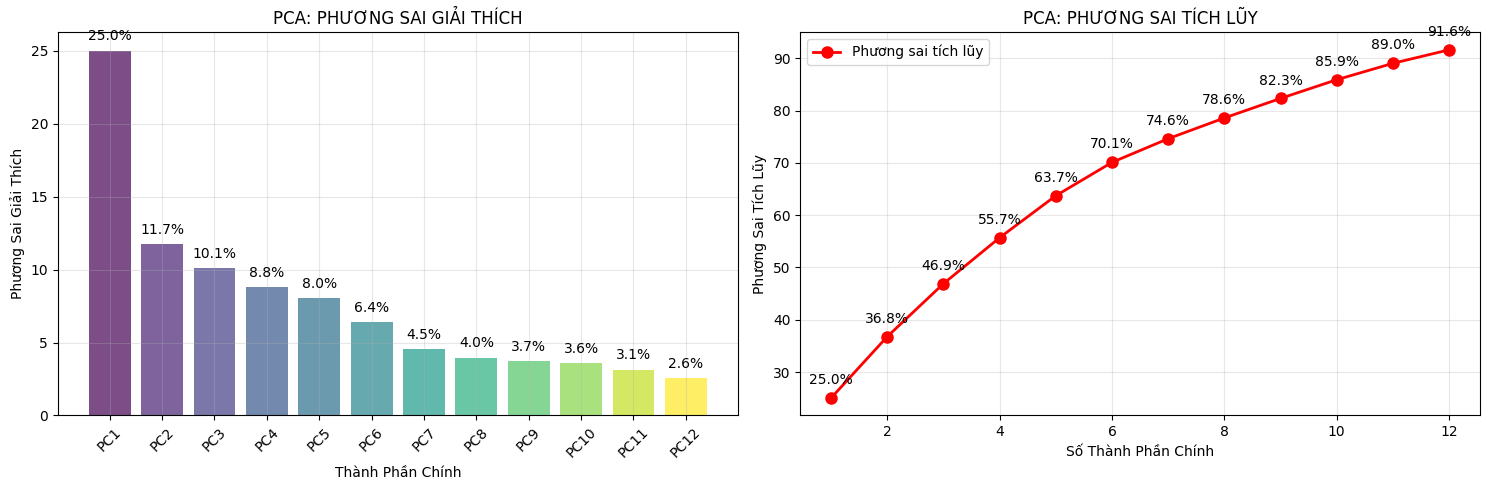

In [ ]:
# Phương sai giải thích
for i in range(n_components_viz):
    print(explained_variance_real[i])
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
components = [f'PC{i+1}' for i in range(n_components_viz)]
variance_values = explained_variance_real[:n_components_viz]
colors = plt.cm.viridis(np.linspace(0, 1, n_components_viz))
bars = plt.bar(components, variance_values, color=colors, alpha=0.7)
plt.xlabel('Thành Phần Chính')
plt.ylabel('Phương Sai Giải Thích')
plt.title('PCA: PHƯƠNG SAI GIẢI THÍCH')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
for bar, variance in zip(bars, variance_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{variance:.1f}%', ha='center', va='bottom', fontsize=10)
plt.subplot(1, 2, 2)
plt.plot(range(1, n_components_viz+1), cumulative_variance_real[:n_components_viz],
         'ro-', linewidth=2, markersize=8, label='Phương sai tích lũy')
plt.xlabel('Số Thành Phần Chính')
plt.ylabel('Phương Sai Tích Lũy')
plt.title('PCA: PHƯƠNG SAI TÍCH LŨY')
plt.grid(True, alpha=0.3)
plt.legend()
for i, (x, y) in enumerate(zip(range(1, n_components_viz+1), cumulative_variance_real[:n_components_viz])):
    plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.savefig('image/pca_explained_variance.png', dpi=300, bbox_inches = 'tight')
plt.show()
#Như vậy với 12 thành phần chính sẽ giải thích được 90,1% phương sai

PC1: 0.0043
PC2: -0.0040
PC3: -0.0025
PC4: -0.0120
PC5: -0.0222
PC6: -0.0036
PC7: 0.0132
PC8: -0.0060
PC9: 0.0056
PC10: 0.0054
PC11: -0.0069
PC12: 0.0016


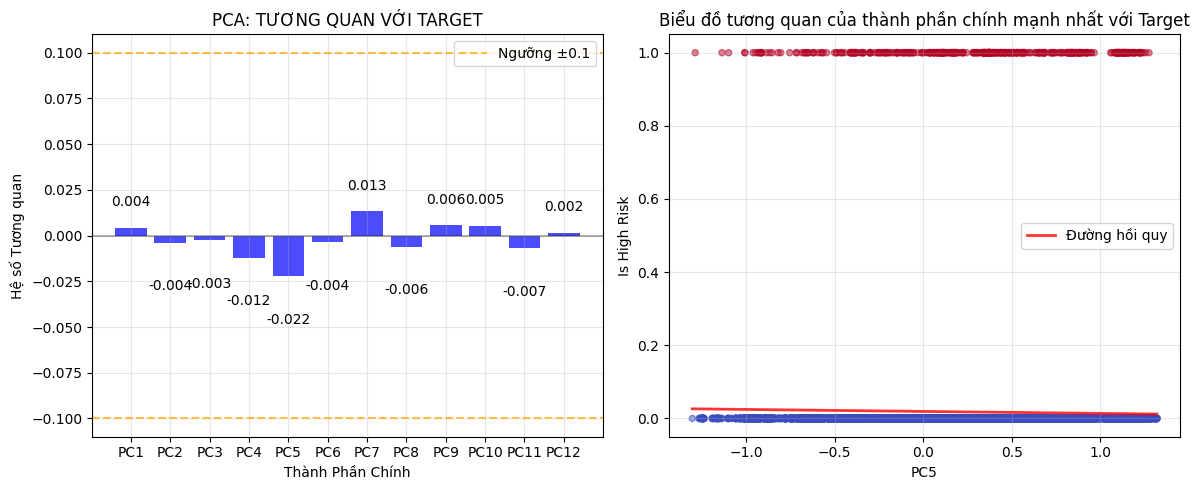

In [ ]:
correlation_results = []
# Ensure 'Is_high_risk' is numeric
pca_df['Is_high_risk'] = pca_df['Is_high_risk'].astype(int)

for i in range(n_components_viz):
    pc_col = f'PC{i+1}'
    corr = np.corrcoef(pca_df[pc_col], pca_df['Is_high_risk'])[0,1]
    correlation_results.append(corr)
    print( f'{pc_col}: {corr:.4f}')
best_pc_idx = np.argmax(np.abs(correlation_results))
best_pc_corr = correlation_results[best_pc_idx]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
colors = ['red' if abs(corr) > 0.1 else 'blue' for corr in correlation_results]
bars = plt.bar(components, correlation_results, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Ngưỡng ±0.1')
plt.axhline(y=-0.1, color='orange', linestyle='--', alpha=0.7)
plt.xlabel('Thành Phần Chính')
plt.ylabel('Hệ số Tương quan')
plt.title('PCA: TƯƠNG QUAN VỚI TARGET')
plt.legend()
plt.grid(True, alpha=0.3)
for bar, corr in zip(bars, correlation_results):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >=0 else -0.02),
             f'{corr:.3f}', ha='center', va='bottom' if height >=0 else 'top', fontsize=10)
plt.subplot(1, 2, 2)
best_pc = f'PC{best_pc_idx+1}'
scatter = plt.scatter(pca_df[best_pc], pca_df['Is_high_risk'],
                     c=pca_df['Is_high_risk'], cmap='coolwarm', alpha=0.5, s=20)
z = np.polyfit(pca_df[best_pc], pca_df['Is_high_risk'], 1)
p = np.poly1d(z)
x_sorted = np.sort(pca_df[best_pc])
plt.plot(x_sorted, p(x_sorted), "r-", linewidth=2, alpha=0.8, label='Đường hồi quy')

plt.xlabel(best_pc)
plt.ylabel('Is High Risk')
plt.title('Biểu đồ tương quan của thành phần chính mạnh nhất với Target')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('image/pca_correlation_target.png', dpi=300, bbox_inches = 'tight')
plt.show()
# Như vậy thành phần chính thứ 3 có tương quan manh nhất với target

## 2.5. LDA

In [ ]:
class SimpleLDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.lda_components = None
        self.explained_variance_ratio = None
        self.scalings_ = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        classes = np.unique(y)
        n_classes = len(classes)
        if self.n_components is None:
            self.n_components = min(n_features, n_classes - 1)
        mean_overall = np.mean(X, axis=0)
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))
        class_means = {}
        class_counts = {}
        for c in classes:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            class_means[c] = mean_c
            class_counts[c] = X_c.shape[0]
            S_W += (X_c - mean_c).T.dot(X_c - mean_c)
            mean_diff = (mean_c - mean_overall).reshape(-1, 1)
            S_B += class_counts[c] * mean_diff.dot(mean_diff.T)

        try:
            S_W_inv = np.linalg.pinv(S_W)
            matrix = S_W_inv.dot(S_B)
            eigenvalues, eigenvectors = np.linalg.eig(matrix)
            idx = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]
            self.lda_components = np.real(eigenvectors[:, :self.n_components])
            self.scalings_ = self.lda_components
            total_variance = np.sum(np.real(eigenvalues))
            self.explained_variance_ratio = np.real(eigenvalues[:self.n_components]) / total_variance
            self.classes_ = classes
            self.class_means_ = class_means
            self.means_ = mean_overall
        except np.linalg.LinAlgError as e:
            print(f"Lỗi trong tính toán LDA: {e}")
            self.lda_components = np.eye(n_features)[:, :self.n_components]
            self.explained_variance_ratio = np.ones(self.n_components) / self.n_components
    def transform(self, X):
        if self.lda_components is None:
            raise ValueError("Chưa fit model LDA")
        return X.dot(self.lda_components)

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
X_lda = data.drop('Is_high_risk', axis=1)

# Apply preprocessing to X
X_lda = preprocessor.fit_transform(X_lda) # Fit and transform the preprocessor for PCA

y_lda = data['Is_high_risk'].values
lda = SimpleLDA(n_components=1)
X_lda = lda.fit_transform(X_lda, y_lda)
lda_df = pd.DataFrame({
    'LDA1': X_lda.flatten(),
    'Is_high_risk': y_lda,
    'Risk_Label': ['Low Risk' if x == 0 else 'High Risk' for x in y_lda]
})

## 2.6. Một số biểu đồ trực quan hóa

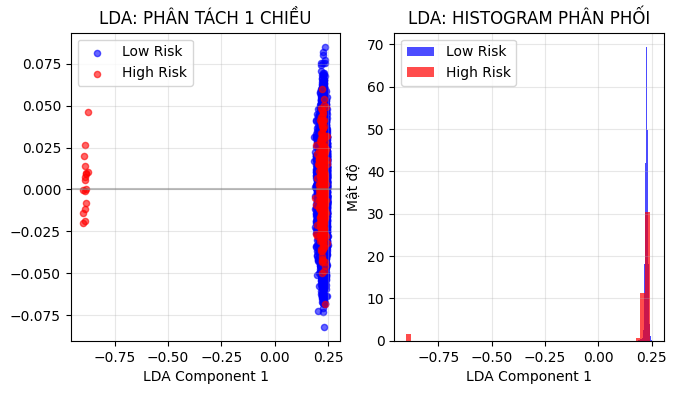

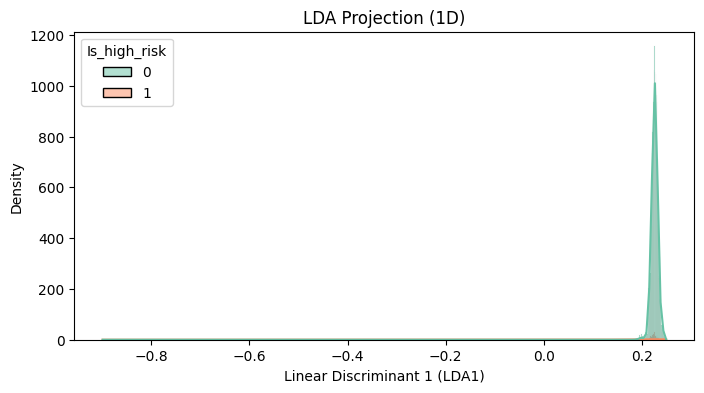

In [ ]:
lda_low = lda_df[lda_df['Is_high_risk'] == 0]['LDA1']
lda_high = lda_df[lda_df['Is_high_risk'] == 1]['LDA1']

mean_low = lda_low.mean()
mean_high = lda_high.mean()
std_low = lda_low.std()
std_high = lda_high.std()
plt.figure(figsize=(16, 4))

# Biểu đồ 1: Scatter plot 1D
plt.subplot(1, 4, 1)
for risk_level, color, label in [(0, 'blue', 'Low Risk'), (1, 'red', 'High Risk')]:
    mask = lda_df['Is_high_risk'] == risk_level
    y_jitter = np.random.normal(0, 0.02, mask.sum())
    plt.scatter(lda_df.loc[mask, 'LDA1'], y_jitter,
               c=color, label=label, alpha=0.6, s=20)
plt.xlabel('LDA Component 1')
plt.title('LDA: PHÂN TÁCH 1 CHIỀU')
plt.axhline(y=0, color='grey', linestyle='-', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

# Biểu đồ 2: Histogram
plt.subplot(1, 4, 2)
plt.hist(lda_low, bins=50, alpha=0.7, color='blue', label='Low Risk', density=True)
plt.hist(lda_high, bins=50, alpha=0.7, color='red', label='High Risk', density=True)
plt.xlabel('LDA Component 1')
plt.ylabel('Mật độ')
plt.title('LDA: HISTOGRAM PHÂN PHỐI')
plt.legend()
plt.grid(True, alpha=0.3)


#
plt.figure(figsize=(8, 4))
sns.histplot(data=lda_df, x='LDA1', hue='Is_high_risk', kde=True, palette='Set2')
plt.title('LDA Projection (1D)')
plt.xlabel('Linear Discriminant 1 (LDA1)')
plt.ylabel('Density')
plt.savefig('image/lda_projection.png', dpi=300, bbox_inches = 'tight')
plt.show()

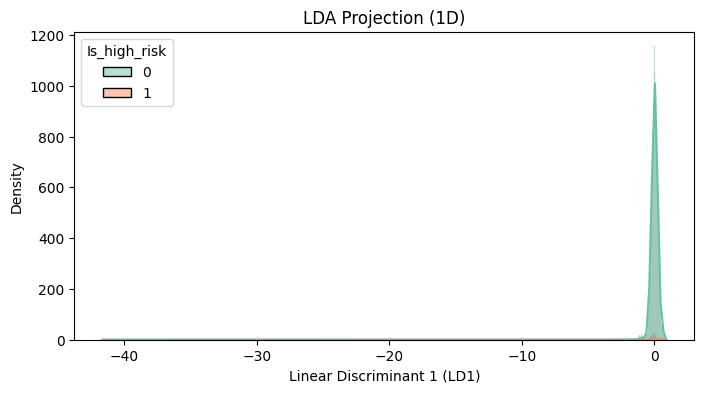

In [ ]:
# Sử dụng thư viện sklearn để kiểm tra lại kết quả
lda = LinearDiscriminantAnalysis(n_components=1)

y_lda_numeric = y_lda.astype(int)

X_lda = lda.fit_transform(X_lda, y_lda_numeric)

# Create a DataFrame for LDA results for easier plotting
lda_df = pd.DataFrame({
    'LDA1': X_lda.flatten(),
    'Is_high_risk': y_lda_numeric,
    'Risk_Label': ['Low Risk' if x == 0 else 'High Risk' for x in y_lda_numeric]
})

# Visualize the LDA-transformed data (1D scatter plot or histogram)
plt.figure(figsize=(8, 4))
sns.histplot(data=lda_df, x='LDA1', hue='Is_high_risk', kde=True, palette='Set2')
plt.title('LDA Projection (1D)')
plt.xlabel('Linear Discriminant 1 (LD1)')
plt.ylabel('Density')
plt.show()

# 3. Phân cụm dữ liệu

In [ ]:
X_cluster = data.drop('Is_high_risk', axis=1)
y_cluster = data['Is_high_risk']

# Apply the preprocessor to X_cluster before clustering
X_cluster_processed = preprocessor.fit_transform(X_cluster)

In [ ]:

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: số chiều
            - init_mu: giá trị khởi tạo cho vector trung bình của các cụm (k, dim)
                           mặc định: lấy ngẫu nhiên từ phân phối đều [-10, 10]
            - init_sigma: giá trị khởi tạo cho ma trận hiệp phương sai của các cụm (k, dim, dim)
                           mặc định: ma trận đơn vị (I) cho mỗi cụm
            - init_pi    :giá trị khởi tạo cho trọng số (xác suất tiên nghiệm) của các cụm (k,)
                           mặc định: trọng số bằng nhau 1/k
            - colors     : màu sắc để vẽ từng cụm (k, 3) – dùng khi trực quan hóa
                           mặc định: màu ngẫu nhiên từ [0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors

    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))

    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            try:
                self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
            except np.linalg.LinAlgError:
                # Fallback nếu ma trận bị suy biến
                self.z[:, i] = 1.0 / self.k

        sum_z = self.z.sum(axis=1, keepdims=True)
        sum_z[sum_z == 0] = 1e-10
        self.z /= sum_z

    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]

    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)

    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [ ]:
def _plot_kmean_scatter(X, labels, gmm_model=None):
  '''
  X: dữ liệu đầu vào
  labels: nhãn dự báo
  '''
  # lựa chọn màu sắc
  if len(labels) == 0:
      return
  num_classes = labels.max() + 1
  palette = np.array(sns.color_palette("hls", num_classes))
  # vẽ biểu đồ scatter
  fig = plt.figure(figsize=(12, 8))
  ax = plt.subplot()
  sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(int)])

  # thêm nhãn cho mỗi cluster
  txts = []
  for i in range(num_classes):
    # Vẽ text tên cụm tại trung vị của mỗi cụm
    xtext, ytext = np.median(X[labels == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24, weight='bold')
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)
  if gmm_model is not None:
        print("Đang vẽ các đường bao GMM (Ellipses)...")
        gmm_model.colors = palette
        gmm_model.draw(ax, n_std=2.0, lw=2)
  plt.title('GMM Clustering on PCA Data')
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.show()

In [ ]:
pca_cluster = PCA(n_components=0.8, random_state=42)
X_pca_cluster = pca_cluster.fit_transform(X_cluster_processed)

print("Số chiều sau PCA (80% variance):", X_pca_cluster.shape[1])

Số chiều sau PCA (80% variance): 9


Clusters: 1 | BIC: 397583.75
Clusters: 2 | BIC: 356456.76
Clusters: 3 | BIC: 183164.35
Clusters: 4 | BIC: 4227.35
Clusters: 5 | BIC: -22831.48
Clusters: 6 | BIC: -9741.45
Clusters: 7 | BIC: 1164.18
Clusters: 8 | BIC: -30869.56
Clusters: 9 | BIC: -57047.46
Clusters: 10 | BIC: -58054.53
Clusters: 11 | BIC: -19712.94
Clusters: 12 | BIC: 31124.36
Clusters: 13 | BIC: -46836.44
Clusters: 14 | BIC: 97954.80


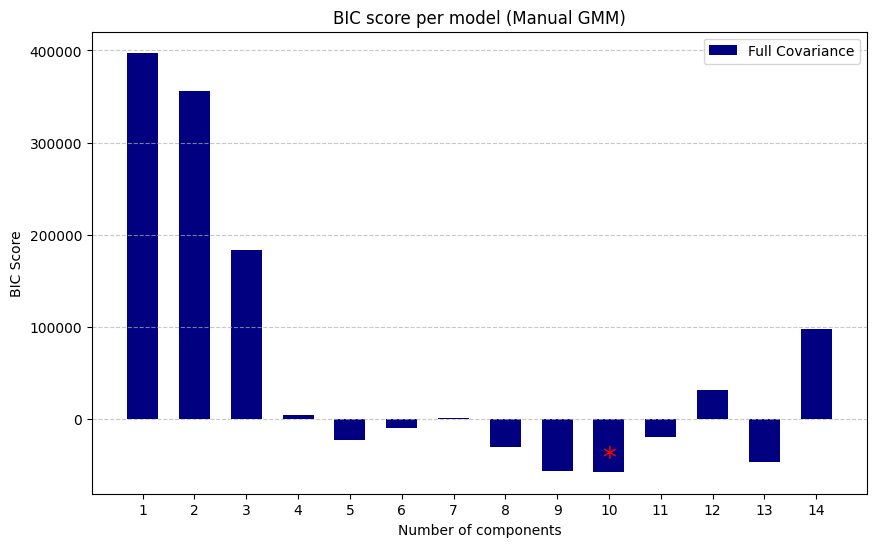

Mô hình tốt nhất có 10 cụm với BIC = -58054.53


In [ ]:
n_components_range = range(1, 15)
bic_scores = []
lowest_bic = np.inf
best_gmm = None

n_samples, n_features = X_pca_cluster.shape

for n_components in n_components_range:
    gmm = GMM(k=n_components, dim=n_features)
    gmm.init_em(X_pca_cluster)
    try:
        for _ in range(30):
            gmm.e_step()
            gmm.m_step()
    except np.linalg.LinAlgError:
        bic_scores.append(np.inf)
        continue
    log_likelihood = gmm.log_likelihood(X_pca_cluster)
    n_params = n_components * (n_features + n_features * (n_features + 1) / 2 + 1) - 1
    current_bic = n_params * np.log(n_samples) - 2 * log_likelihood
    bic_scores.append(current_bic)
    if current_bic < lowest_bic:
        lowest_bic = current_bic
        best_gmm = gmm
    print(f"Clusters: {n_components} | BIC: {current_bic:.2f}")
bic_scores = np.array(bic_scores)
# Loại bỏ các giá trị inf nếu có lỗi
valid_indices = ~np.isinf(bic_scores)
bic_scores_clean = bic_scores[valid_indices]
n_range_clean = np.array(n_components_range)[valid_indices]

plt.figure(figsize=(10, 6))
bars = plt.bar(n_range_clean, bic_scores_clean, width=0.6, color='navy', label='Full Covariance')

plt.xticks(n_range_clean)
plt.title('BIC score per model (Manual GMM)')
plt.xlabel('Number of components')
plt.ylabel('BIC Score')

if len(bic_scores_clean) > 0:
    best_idx = np.argmin(bic_scores_clean)
    best_x = n_range_clean[best_idx]
    best_y = bic_scores_clean[best_idx]
    y_min = best_y
    y_max = bic_scores_clean.max()
    plt.ylim([y_min * 1.01 - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)])

    plt.text(best_x, best_y, '*', fontsize=20, ha='center', va='bottom', color='red')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Mô hình tốt nhất có {best_gmm.k} cụm với BIC = {lowest_bic:.2f}")

In [ ]:
num = best_gmm.k
gmm = GMM(k=num, dim=X_pca_cluster.shape[1])
gmm.init_em(X_pca_cluster)

for _ in range(50):
    gmm.e_step()
    try:
        gmm.m_step()
    except np.linalg.LinAlgError:
        print("Suy biến ma trận → dừng")
        break

labels = np.argmax(gmm.z, axis=1)
print("Số cụm thực tế:", len(np.unique(labels)))

Số cụm thực tế: 6


In [ ]:
# PCA 2D để vẽ
pca_viz = PCA(n_components=2, random_state=42)
X_pca_2d = pca_viz.fit_transform(X_cluster_processed)

In [ ]:
n_clusters = len(np.unique(labels))
print(f"Số lượng cụm tìm thấy: {n_clusters}")

Số lượng cụm tìm thấy: 6


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


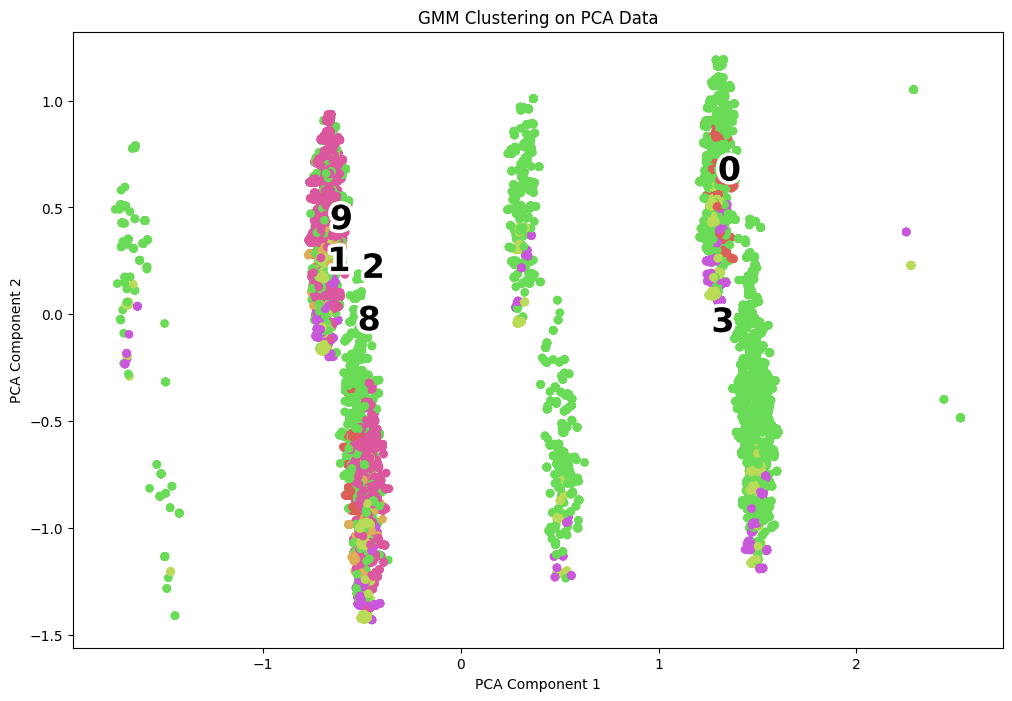

In [ ]:
palette = np.array(sns.color_palette("hls", len(np.unique(labels))))
gmm.colors = palette

_plot_kmean_scatter(X_pca_2d, labels, gmm_model=None)

In [ ]:
def silhouette_metric(X, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) < 2:
        return np.nan
    return silhouette_score(X[mask], labels[mask])
def dunn_index(X, labels):
    mask = labels != -1
    X = X[mask]
    labels = labels[mask]

    clusters = np.unique(labels)
    if len(clusters) < 2:
        return np.nan

    distances = pairwise_distances(X)

    # Đường kính cụm (intra-cluster max distance)
    intra_dists = []
    for c in clusters:
        idx = np.where(labels == c)[0]
        if len(idx) > 1:
            intra_dists.append(np.max(distances[np.ix_(idx, idx)]))
    max_intra = np.max(intra_dists)

    # Khoảng cách giữa các cụm (inter-cluster min)
    inter_dists = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            idx_i = np.where(labels == clusters[i])[0]
            idx_j = np.where(labels == clusters[j])[0]
            inter_dists.append(np.min(distances[np.ix_(idx_i, idx_j)]))

    return np.min(inter_dists) / max_intra
def build_knn_graph(X, k=10):
    dist = pairwise_distances(X)
    np.fill_diagonal(dist, np.inf)

    G = nx.Graph()
    for i in range(len(X)):
        neighbors = np.argsort(dist[i])[:k]
        for j in neighbors:
            weight = np.exp(-dist[i, j])  # similarity
            G.add_edge(i, j, weight=weight)
    return G
def modularity_metric(X, labels, k=10):
    mask = labels != -1
    X = X[mask]
    labels = labels[mask]

    if len(np.unique(labels)) < 2:
        return np.nan

    G = build_knn_graph(X, k=k)

    communities = {}
    for i, c in enumerate(labels):
        communities.setdefault(c, []).append(i)

    return nx.algorithms.community.quality.modularity(
        G, communities.values(), weight='weight'
    )
def davies_bouldin_metric(X, labels):
    mask = labels != -1
    X = X[mask]
    labels = labels[mask]

    if len(np.unique(labels)) < 2:
        return np.nan

    return davies_bouldin_score(X, labels)

In [ ]:
print("Silhouette:", silhouette_metric(X_pca_cluster, labels))
print("Dunn:", dunn_index(X_pca_cluster, labels))
print("Modularity:", modularity_metric(X_pca_cluster, labels))
print("Davies-Bouldin:", davies_bouldin_metric(X_pca_cluster, labels))

Silhouette: 0.008951751539715965
Dunn: 0.008683280546998818
Modularity: 0.7360751004307493
Davies-Bouldin: 3.575264692501895


In [ ]:
df_gmm = data.copy()
df_gmm['Cluster'] = labels

summary_gmm = (
    df_gmm
    .groupby('Cluster')['Is_high_risk']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

summary_gmm


Cluster      mean       std  count
0        0  0.011057  0.104599   1628
1        1  0.017717  0.131984   1016
2        2   0.01526  0.122597   5308
3        3  0.019707  0.139000   9844
4        8  0.014272  0.118638   2032
5        9  0.015793  0.124681   9751

## DBScan

In [ ]:
from collections import deque

class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        self.n_samples = 0

    def fit(self, X):
        # Lưu dữ liệu vào object để dùng sau (không tính ma trận full)
        self.X = np.array(X, dtype=float)
        self.n_samples = self.X.shape[0]

        # -1: Noise/Unvisited
        self.labels_ = np.full(self.n_samples, -1, dtype=int)

        # Visited flags: Để phân biệt giữa Noise (-1) và Chưa thăm
        self.visited = np.zeros(self.n_samples, dtype=bool)

        cluster_id = 0

        for i in range(self.n_samples):
            if self.visited[i]:
                continue

            self.visited[i] = True
            neighbors = self._region_query(i)

            if len(neighbors) < self.min_samples:
                continue
            else:
                # Nếu đủ hàng xóm -> Là Core Point -> Tạo cụm mới
                self._expand_cluster(i, neighbors, cluster_id)
                cluster_id += 1

        return self

    def _region_query(self, idx):
        """
        Tính khoảng cách từ điểm idx đến TẤT CẢ các điểm khác.
        Chỉ tính vector này khi cần, không lưu matrix -> Tiết kiệm RAM.
        """
        # Euclidean distance: sqrt(sum((x - y)^2))
        # Axis 1 là tổng theo hàng
        dist = np.linalg.norm(self.X - self.X[idx], axis=1)

        # Lấy index các điểm có khoảng cách <= eps
        return np.where(dist <= self.eps)[0].tolist()

    def _expand_cluster(self, idx, neighbors, cluster_id):
        """Mở rộng cụm"""
        self.labels_[idx] = cluster_id  # Gán nhãn cho điểm core

        queue = deque(neighbors) # Hàng đợi các điểm cần xét

        while queue:
            current_point = queue.popleft()

            # Nếu chưa thăm thì đánh dấu đã thăm
            if not self.visited[current_point]:
                self.visited[current_point] = True

                # Tìm hàng xóm của điểm này
                current_neighbors = self._region_query(current_point)
                if len(current_neighbors) >= self.min_samples:
                    queue.extend(current_neighbors)
            if self.labels_[current_point] == -1:
                self.labels_[current_point] = cluster_id

    def get_info(self):
        n_clusters = len(set(self.labels_)) - (1 if -1 in self.labels_ else 0)
        n_noise = list(self.labels_).count(-1)
        print(f"Số lượng cụm tìm thấy: {n_clusters}")
        print(f"Số điểm nhiễu (Noise): {n_noise}")

In [ ]:
pca = PCA(n_components= 2)
# Use the already processed numerical data
X_pca = pca.fit_transform(X_cluster_processed)

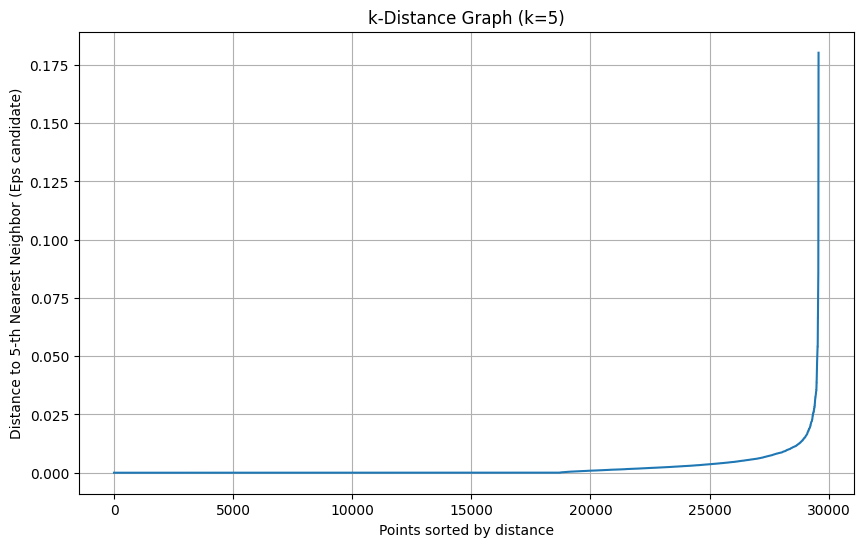

In [ ]:
from sklearn.neighbors import NearestNeighbors

k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)
k_distances = distances[:, k-1]
k_distances = np.sort(k_distances)

# 5. Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title(f'k-Distance Graph (k={k})')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor (Eps candidate)')
plt.xlabel('Points sorted by distance')
plt.grid(True)
plt.savefig('image/k_distance_graph.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

best_eps = None
best_score = -1
best_noise_ratio = np.inf
for eps in np.arange(0.01, 0.1, 0.005):
    db = DBSCAN(eps=eps, min_samples=5).fit(X_pca)
    labels = db.labels_

    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    noise_ratio = n_noise / len(X_pca)
    if 2 <= n_clusters <= 15 and noise_ratio < 0.3 :
        core_samples_mask = labels != -1
        if np.sum(core_samples_mask) > 0: # Phải có điểm không phải nhiễu
            score = silhouette_score(X_pca[core_samples_mask], labels[core_samples_mask])

            print(f"Eps: {eps:.2f} | Clusters: {n_clusters} | Noise: {list(labels).count(-1)} | Score: {score:.3f}")

            if score > best_score and noise_ratio < best_noise_ratio:
                best_score = score
                best_eps = eps
                best_noise_ratio = noise_ratio

print(f"\n=> Best Eps: {best_eps} with Silhouette Score: {best_score}")

Eps: 0.08 | Clusters: 14 | Noise: 8 | Score: 0.290
Eps: 0.08 | Clusters: 14 | Noise: 8 | Score: 0.290
Eps: 0.09 | Clusters: 13 | Noise: 8 | Score: 0.289
Eps: 0.09 | Clusters: 12 | Noise: 8 | Score: 0.290

=> Best Eps: 0.07999999999999999 with Silhouette Score: 0.2895241697534236


Số lượng cụm tìm thấy: 14
Số điểm nhiễu (Noise): 8


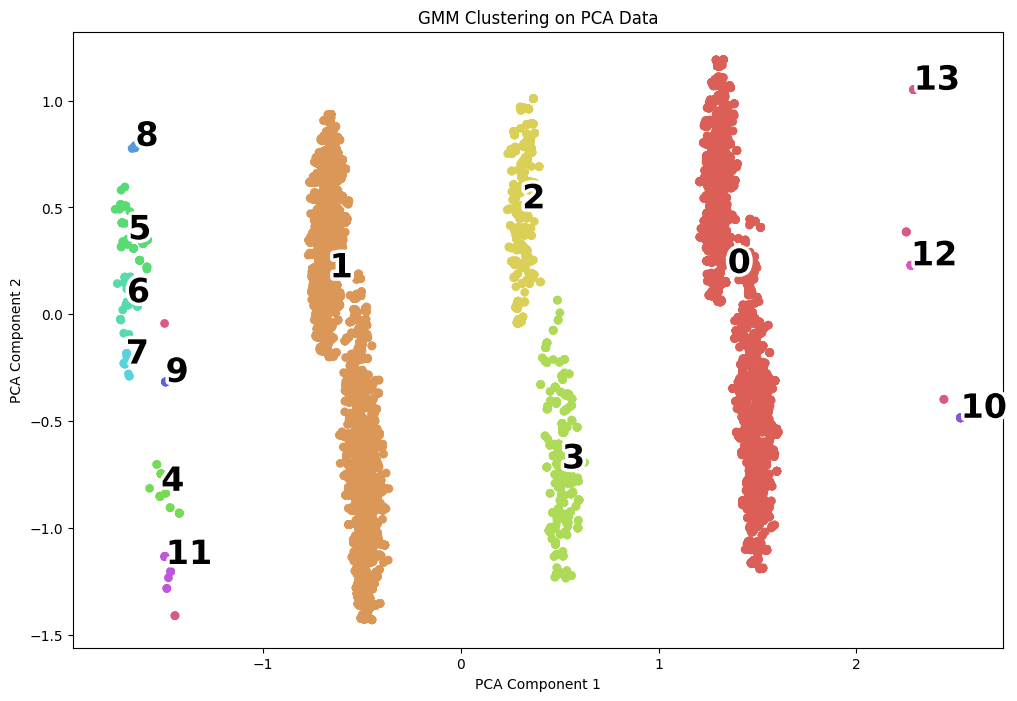

In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples=5)
dbscan.fit(X_pca)

dbscan.get_info()
_plot_kmean_scatter(X_pca, dbscan.labels_)

In [ ]:
labels = dbscan.labels_
print("Dunn:", dunn_index(X_pca_cluster, labels))
print("Modularity:", modularity_metric(X_pca_cluster, labels))
print("Davies-Bouldin:", davies_bouldin_metric(X_pca_cluster, labels))

Dunn: 0.22060528671654825
Modularity: 0.4659594312911417
Davies-Bouldin: 1.8502136906781914


In [ ]:
df_dbs = data.copy()
df_dbs['Cluster'] = labels

summary_dbs = (
    df_dbs
    .groupby('Cluster')['Is_high_risk']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

summary_dbs


Cluster      mean       std  count
0        -1       0.0  0.000000      8
1         0  0.017593  0.131475   8526
2         1  0.015748  0.124501  19495
3         2   0.02356  0.151774    764
4         3  0.020036  0.140253    549
5         4       0.0  0.000000     32
6         5  0.044444  0.207235     90
7         6  0.025641  0.160128     39
8         7      0.05  0.223607     20
9         8  0.076923  0.277350     13
10        9       0.0  0.000000      5
11       10       0.0  0.000000     12
12       11  0.083333  0.288675     12
13       12       0.0  0.000000      8
14       13       0.0  0.000000      6

# 4. Xây dựng mô hình

## 4.1. Một số hàm cần thiết cho huấn luyện

In [ ]:
def data_split(df, test_size):
    df["Is_high_risk"] = pd.to_numeric(df["Is_high_risk"])
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

    X_train = train_df.drop('Is_high_risk', axis=1)
    y_train = train_df['Is_high_risk']
    X_test = test_df.drop('Is_high_risk', axis=1)
    y_test = test_df['Is_high_risk']
    return X_train.reset_index(drop=True), y_train.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

def SMOTE_oversample(X, y):
    oversample = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = oversample.fit_resample(X, y)

    return X_resampled, y_resampled

def RandomSampler(X, y):
  oversample = RandomOverSampler(sampling_strategy='minority')
  X_resampled, y_resampled = oversample.fit_resample(X, y)

  return X_resampled, y_resampled

In [ ]:
def print_confusion_matrix(name_model, y_pred, y_test, radio):
    fig, ax = plt.subplots(figsize=(8,8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues',values_format='d')
    plt.grid(False)

    # Title
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.title(f'Confusion Matrix {name_model}', fontsize=14)

    plt.savefig(f'image/Confusion_Matrix_{name_model}_{radio}.png', dpi = 300, bbox_inches = 'tight')
    #show the plot
    plt.show()

In [ ]:
# hàm để in đường cong ROC cho nhiều mô hình phân loại nhị phân
def plot_roc_curves_binary(models_list, y_test, y_pred):
    plt.figure(figsize=(10, 8))

    # Vẽ đường chéo (mô hình đoán ngẫu nhiên)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', alpha=0.7)

    for model_info in models_list:
        name = model_info['name']
        radio = model_info['radio']

        # Tính FPR, TPR và AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred)

         # Vẽ đường cong ROC
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves {name}')
    plt.legend(loc='lower right')
    plt.grid(False)
    plt.savefig(f'image/ROC_Curves_{name}_{radio}.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

## 4.2. Xây dựng mô hình

### 4.2.1. MLP

In [ ]:
import numpy as np

class ManualMLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # 1. Cải thiện khởi tạo trọng số (He Initialization cho ReLU)
        # Giúp gradient không bị biến mất hoặc bùng nổ ngay từ đầu
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2. / self.input_size)
        self.b1 = np.zeros((1, self.hidden_size))

        # Xavier Initialization cho lớp Output (Sigmoid)
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(1. / self.hidden_size)
        self.b2 = np.zeros((1, self.output_size))

    def _sigmoid(self, x):
        # Thêm clip để tránh tràn số (overflow)
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return (x > 0).astype(float)

    def fit(self, X, y, epochs=100, batch_size=32):
        num_samples = X.shape[0]
        y_processed = y.reshape(-1, 1)

        for epoch in range(epochs):
            # Shuffle
            permutation = np.random.permutation(num_samples)
            X_shuffled = X[permutation]
            y_shuffled = y_processed[permutation]

            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                # --- Forward propagation ---
                # Layer 1: Dùng ReLU
                self.z1 = np.dot(X_batch, self.W1) + self.b1
                self.a1 = self._relu(self.z1)

                # Layer 2 (Output): Dùng Sigmoid
                self.z2 = np.dot(self.a1, self.W2) + self.b2
                self.a2 = self._sigmoid(self.z2)

                # --- Backpropagation (Dùng Cross-Entropy Loss) ---

                # 2. Cải thiện đạo hàm:
                # Với Cross-Entropy + Sigmoid, đạo hàm đơn giản là (Output - Target)
                # Không cần nhân với sigmoid_derivative nữa (Toán học chứng minh điều này giúp học nhanh hơn)
                delta_output = self.a2 - y_batch

                # Tính lỗi lùi về lớp ẩn
                error_hidden = np.dot(delta_output, self.W2.T)
                # Nhân với đạo hàm ReLU
                delta_hidden = error_hidden * self._relu_derivative(self.z1)

                # Cập nhật trọng số
                self.W2 -= self.learning_rate * np.dot(self.a1.T, delta_output)
                self.b2 -= self.learning_rate * np.sum(delta_output, axis=0, keepdims=True)
                self.W1 -= self.learning_rate * np.dot(X_batch.T, delta_hidden)
                self.b1 -= self.learning_rate * np.sum(delta_hidden, axis=0, keepdims=True)

            # Monitor Loss (Log Loss)
            if (epoch + 1) % 10 == 0:
                # Forward pass toàn bộ data để tính loss chuẩn
                z1 = np.dot(X, self.W1) + self.b1
                a1 = self._relu(z1)
                z2 = np.dot(a1, self.W2) + self.b2
                a2 = self._sigmoid(z2)

                # Tính Binary Cross Entropy Loss
                epsilon = 1e-15 # Tránh log(0)
                a2 = np.clip(a2, epsilon, 1 - epsilon)
                loss = -np.mean(y_processed * np.log(a2) + (1 - y_processed) * np.log(1 - a2))

                print(f'Epoch {epoch+1}/{epochs}, Log Loss: {loss:.4f}')

    def predict_proba(self, X):
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self._relu(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        return self._sigmoid(z2)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

print("Đã xây dựng class ManualMLP tối ưu hóa")

Đã xây dựng class ManualMLP tối ưu hóa


### 4.2.2. Gradient Boosting

In [ ]:
class ManualGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None

    def _sigmoid(self, x):
        # Helper method to convert log-odds to probabilities
        return 1 / (1 + np.exp(-x))

    def _compute_pseudo_residuals(self, y_true, y_pred_log_odds):
        # Calculate probabilities from log-odds
        p = self._sigmoid(y_pred_log_odds)
        # Calculate pseudo-residuals (negative gradient for logistic loss)
        return y_true - p

    def fit(self, X, y):
        self.trees = []

        # Initialize the first prediction (log-odds of the mean of the target variable)
        p_initial = np.mean(y)
        self.initial_prediction = np.log(p_initial / (1 - p_initial))

        # Initialize current predictions as a full array for all samples
        current_predictions_log_odds = np.full(y.shape, self.initial_prediction)

        for i in range(self.n_estimators):
            # Calculate pseudo-residuals
            residuals = self._compute_pseudo_residuals(y, current_predictions_log_odds)

            # Instantiate a DecisionTreeRegressor
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42 + i)

            # Fit the tree to the negative gradients (pseudo-residuals)
            tree.fit(X, residuals)

            # Store the trained tree
            self.trees.append(tree)

            # Update the overall predictions
            # Convert tree predictions to 1D array if needed
            tree_predictions = tree.predict(X)
            current_predictions_log_odds += self.learning_rate * tree_predictions

    def predict_proba(self, X):
        # Start with the initial prediction (log-odds)
        # Ensure initial_prediction is broadcastable if X has many rows
        final_log_odds = np.full(X.shape[0], self.initial_prediction)

        # Sum the predictions from all trained DecisionTreeRegressor models
        for tree in self.trees:
            final_log_odds += self.learning_rate * tree.predict(X)

        # Apply the sigmoid function to convert log-odds to probabilities
        return self._sigmoid(final_log_odds)

    def predict(self, X):
        # Get probabilities
        probabilities = self.predict_proba(X)
        # Convert probabilities to binary class labels (0 or 1) using a threshold of 0.5
        return (probabilities >= 0.5).astype(int)

print("Xây dựng thành công Class GradientBoosting")

Xây dựng thành công Class GradientBoosting


### 4.2.3. SVM

In [ ]:
from sklearn.svm._base import BaseSVC, BaseLibSVM

class RBF_SVC(BaseSVC):
    """
    Class này kế thừa toàn bộ sức mạnh của BaseSVC và BaseLibSVM
    """

    _impl = "c_svc"

    def __init__(
        self,
        C=1.0,
        gamma="scale",
        tol=1e-3,
        shrinking=True,
        probability=False,
        cache_size=200,
        class_weight=None,
        verbose=False,
        max_iter=-1,
        decision_function_shape="ovr",
        break_ties=False,
        random_state=None,
    ):

        super().__init__(
            kernel="rbf",  # Cố định kernel là RBF
            degree=3,      # Bỏ qua (chỉ dùng cho poly)
            gamma=gamma,   # Quan trọng với RBF
            coef0=0.0,     # Bỏ qua (chỉ dùng cho sigmoid/poly)
            tol=tol,
            C=C,
            nu=0.0,        # Bỏ qua (chỉ dùng cho NuSVC)
            shrinking=shrinking,
            probability=probability,
            cache_size=cache_size,
            class_weight=class_weight,
            verbose=verbose,
            max_iter=max_iter,
            decision_function_shape=decision_function_shape,
            random_state=random_state,
            break_ties=break_ties,
        )

    def fit(self, X, y, sample_weight=None):
        # Gọi hàm fit của BaseLibSVM
        return super().fit(X, y, sample_weight)

    @property
    def implementation_type(self):
        return "c_svc"

    def get_gamma_value(self):
        if hasattr(self, "_gamma"):
            return self._gamma
        else:
            raise AttributeError("Mô hình chưa được huấn luyện (fit).")


# 5. Huấn luyện mô hình

## 5.1. Huấn luyện mô hình với tập train/test tỉ lệ 4/1

In [ ]:
# Re-split the data to ensure fresh start for this cell
X_train_raw, y_train_raw, X_test_raw, y_test_raw = data_split(data, test_size=0.2)

# Preprocess the data using the defined preprocessor
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

# Apply SMOTE oversampling to the training data, correctly assigning outputs
X_train_smoted, y_train_smoted = SMOTE_oversample(X_train_processed, y_train_raw)
X_test_smoted, y_test_smoted = SMOTE_oversample(X_test_processed, y_test_raw)

Epoch 10/300, Log Loss: 0.2977
Epoch 20/300, Log Loss: 0.1806
Epoch 30/300, Log Loss: 0.1577
Epoch 40/300, Log Loss: 0.1301
Epoch 50/300, Log Loss: 0.1385
Epoch 60/300, Log Loss: 0.1294
Epoch 70/300, Log Loss: 0.1587
Epoch 80/300, Log Loss: 0.1273
Epoch 90/300, Log Loss: 0.1362
Epoch 100/300, Log Loss: 0.1078
Epoch 110/300, Log Loss: 0.1061
Epoch 120/300, Log Loss: 0.0916
Epoch 130/300, Log Loss: 0.0998
Epoch 140/300, Log Loss: 0.0971
Epoch 150/300, Log Loss: 0.1015
Epoch 160/300, Log Loss: 0.0916
Epoch 170/300, Log Loss: 0.1077
Epoch 180/300, Log Loss: 0.1015
Epoch 190/300, Log Loss: 0.0933
Epoch 200/300, Log Loss: 0.1278
Epoch 210/300, Log Loss: 0.0927
Epoch 220/300, Log Loss: 0.0791
Epoch 230/300, Log Loss: 0.0784
Epoch 240/300, Log Loss: 0.0814
Epoch 250/300, Log Loss: 0.0799
Epoch 260/300, Log Loss: 0.0819
Epoch 270/300, Log Loss: 0.1074
Epoch 280/300, Log Loss: 0.1682
Epoch 290/300, Log Loss: 0.0803
Epoch 300/300, Log Loss: 0.0883

--- Evaluation of Manual MLP Model ---
Classific

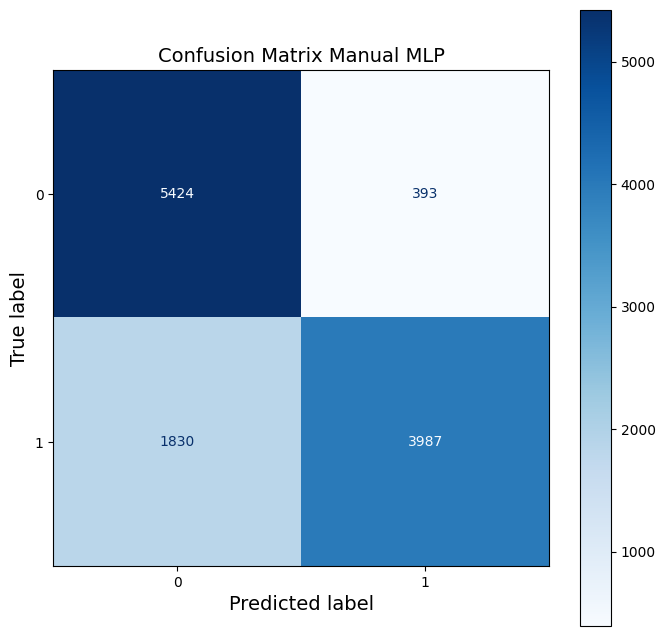


 ROC Curves:


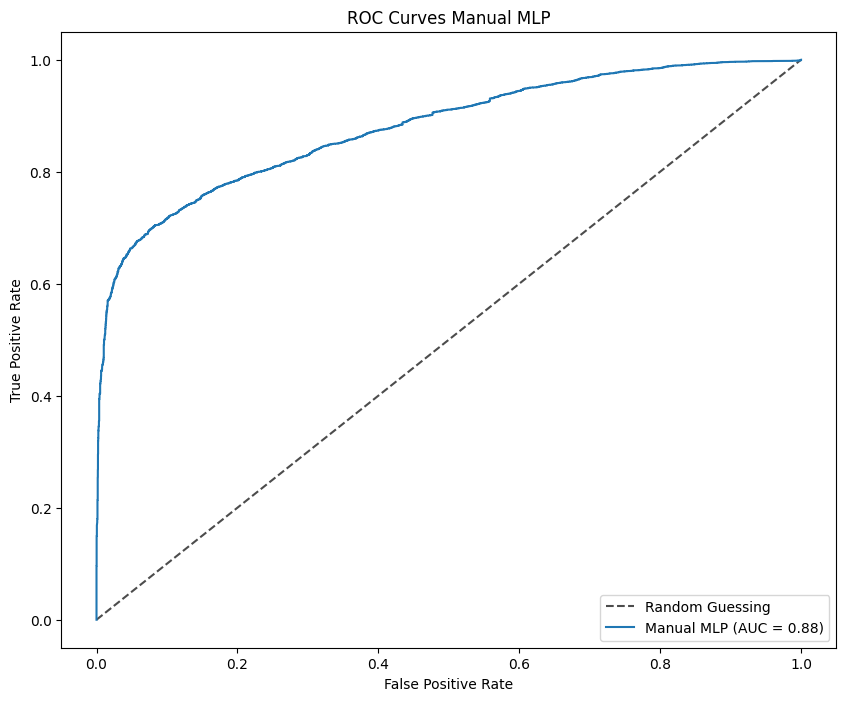

In [ ]:
# Initialize and train the manual MLP model
mlp_manual_model = ManualMLP(input_size=X_train_smoted.shape[1],
                                      hidden_size=256, # Increased hidden_size from 128 to 256
                                      output_size=1,
                                      learning_rate=0.005) # You can adjust learning_rate

mlp_manual_model.fit(X_train_smoted, y_train_smoted.values, epochs=300, batch_size=32)

# Predict on the test set
y_pred_manual_mlp = mlp_manual_model.predict(X_test_smoted)
y_pred_prob_mlp = mlp_manual_model.predict_proba(X_test_smoted)

# Evaluate the model
print("\n--- Evaluation of Manual MLP Model ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_mlp))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual MLP", y_pred_manual_mlp, y_test_smoted, "4:1")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual MLP', 'radio': '4:1'}], y_test_smoted, y_pred_prob_mlp.flatten())


--- Evaluation of Manual Gradient Boosting Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      5817
           1       0.85      0.79      0.82      5817

    accuracy                           0.83     11634
   macro avg       0.83      0.83      0.83     11634
weighted avg       0.83      0.83      0.83     11634


Confusion Matrix:


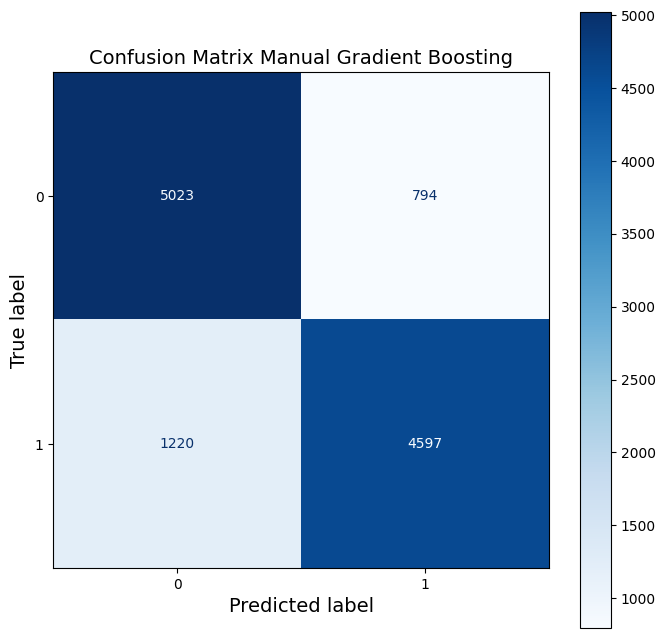


 ROC Curves:


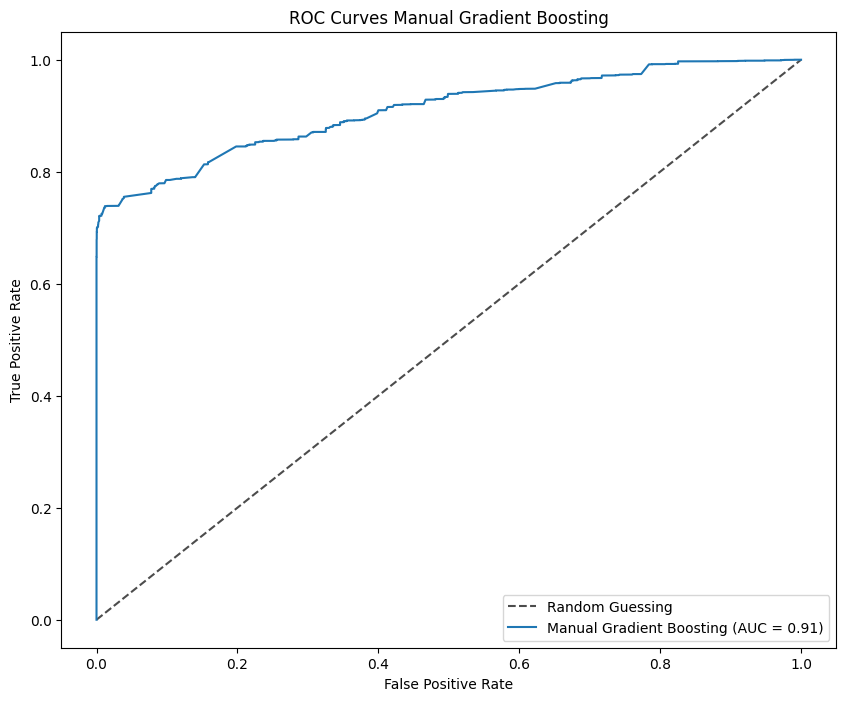

In [ ]:
manual_gradient_model = ManualGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
manual_gradient_model.fit(X_train_smoted, y_train_smoted)
y_pred_manual_gradient = manual_gradient_model.predict(X_test_smoted)
y_pred_prod_gradient = manual_gradient_model.predict_proba(X_test_smoted)

print("\n--- Evaluation of Manual Gradient Boosting Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_gradient))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual Gradient Boosting", y_pred_manual_gradient, y_test_smoted, "4:1")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual Gradient Boosting', 'radio': '4:1'}], y_test_smoted, y_pred_prod_gradient)


--- Evaluation of RBF SVM Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      5817
           1       0.87      0.85      0.86      5817

    accuracy                           0.86     11634
   macro avg       0.86      0.86      0.86     11634
weighted avg       0.86      0.86      0.86     11634


Confusion Matrix:


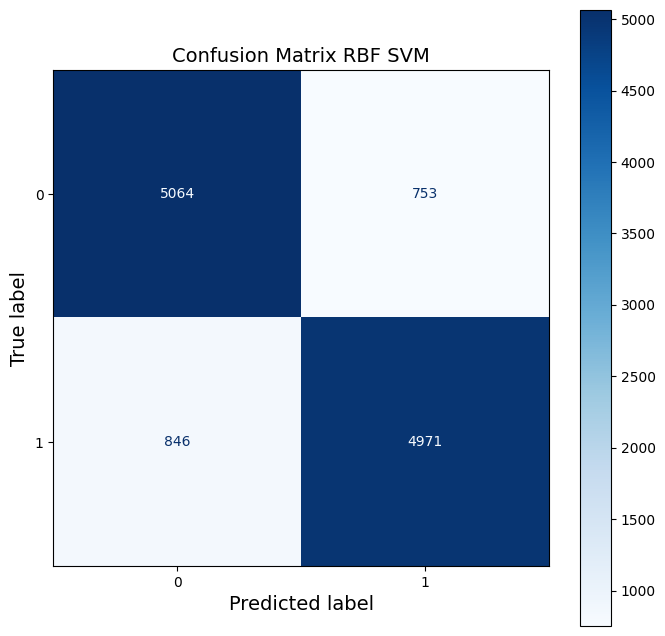


 ROC Curves:


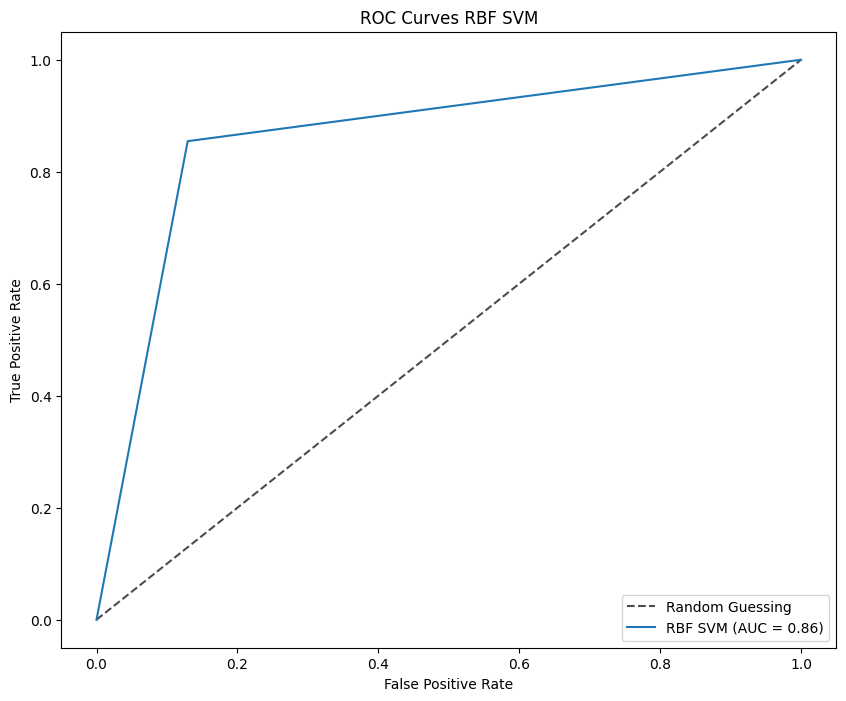

In [ ]:
svc_model = RBF_SVC(C=10.0, gamma='scale')
svc_model.fit(X_train_smoted, y_train_smoted)
y_pred_svc = svc_model.predict(X_test_smoted)

print("\n--- Evaluation of RBF SVM Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_svc))
print("\nConfusion Matrix:")
print_confusion_matrix("RBF SVM", y_pred_svc, y_test_smoted, "4:1")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'RBF SVM', 'radio': '4:1'}], y_test_smoted, y_pred_svc)

## 5.2. Huấn luyện mô hình với tập train/test tỉ lệ 7/3

In [ ]:
# Re-split the data to ensure fresh start for this cell
X_train_raw, y_train_raw, X_test_raw, y_test_raw = data_split(data, test_size=0.3)

# Preprocess the data using the defined preprocessor
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

# Apply SMOTE oversampling to the training data, correctly assigning outputs
X_train_smoted, y_train_smoted = SMOTE_oversample(X_train_processed, y_train_raw)
X_test_smoted, y_test_smoted = SMOTE_oversample(X_test_processed, y_test_raw)

Epoch 10/300, Log Loss: 0.2323
Epoch 20/300, Log Loss: 0.1992
Epoch 30/300, Log Loss: 0.1642
Epoch 40/300, Log Loss: 0.1198
Epoch 50/300, Log Loss: 0.1277
Epoch 60/300, Log Loss: 0.1091
Epoch 70/300, Log Loss: 0.1065
Epoch 80/300, Log Loss: 0.1083
Epoch 90/300, Log Loss: 0.0967
Epoch 100/300, Log Loss: 0.0908
Epoch 110/300, Log Loss: 0.1017
Epoch 120/300, Log Loss: 0.1147
Epoch 130/300, Log Loss: 0.0958
Epoch 140/300, Log Loss: 0.0906
Epoch 150/300, Log Loss: 0.0838
Epoch 160/300, Log Loss: 0.0842
Epoch 170/300, Log Loss: 0.0841
Epoch 180/300, Log Loss: 0.0765
Epoch 190/300, Log Loss: 0.0887
Epoch 200/300, Log Loss: 0.0749
Epoch 210/300, Log Loss: 0.0777
Epoch 220/300, Log Loss: 0.0724
Epoch 230/300, Log Loss: 0.0887
Epoch 240/300, Log Loss: 0.0850
Epoch 250/300, Log Loss: 0.0658
Epoch 260/300, Log Loss: 0.0644
Epoch 270/300, Log Loss: 0.0702
Epoch 280/300, Log Loss: 0.0644
Epoch 290/300, Log Loss: 0.0722
Epoch 300/300, Log Loss: 0.0807

--- Evaluation of Manual MLP Model ---
Classific

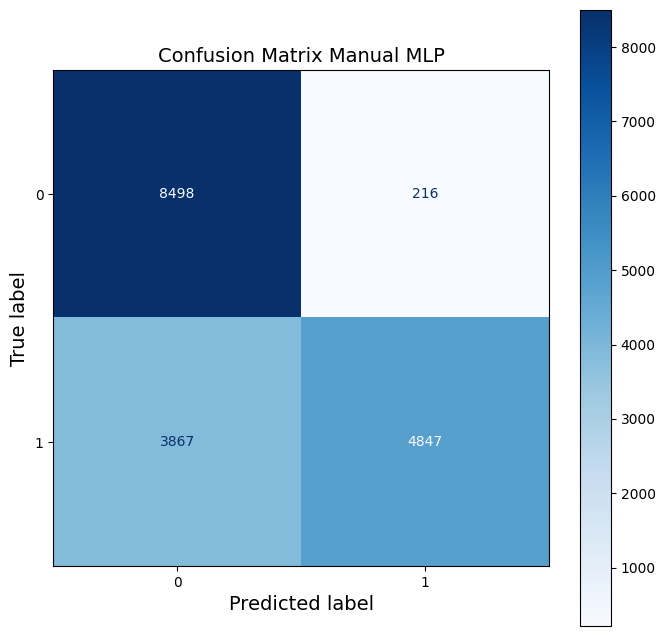


 ROC Curves:


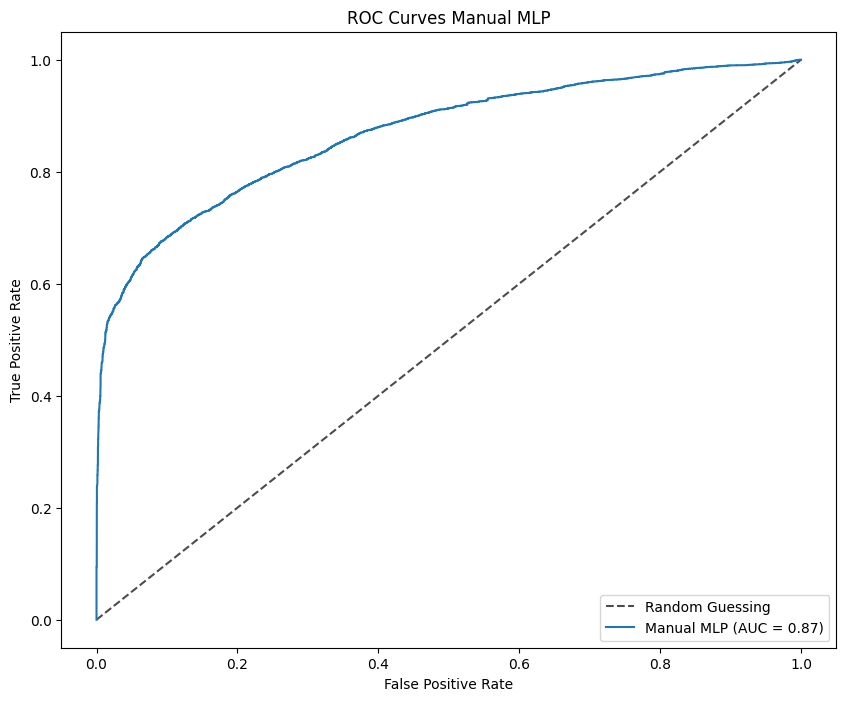

In [ ]:
# Initialize and train the manual MLP model
mlp_manual_model = ManualMLP(input_size=X_train_smoted.shape[1],
                                      hidden_size=256, # Increased hidden_size from 128 to 256
                                      output_size=1,
                                      learning_rate=0.005) # You can adjust learning_rate

mlp_manual_model.fit(X_train_smoted, y_train_smoted.values, epochs=300, batch_size=32)

# Predict on the test set
y_pred_manual_mlp = mlp_manual_model.predict(X_test_smoted)
y_pred_prob_mlp = mlp_manual_model.predict_proba(X_test_smoted)

# Evaluate the model
print("\n--- Evaluation of Manual MLP Model ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_mlp))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual MLP", y_pred_manual_mlp, y_test_smoted, "7:3")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual MLP', 'radio': '7:3'}], y_test_smoted, y_pred_prob_mlp)


--- Evaluation of Manual Gradient Boosting Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      8714
           1       0.86      0.75      0.80      8714

    accuracy                           0.81     17428
   macro avg       0.82      0.81      0.81     17428
weighted avg       0.82      0.81      0.81     17428


Confusion Matrix:


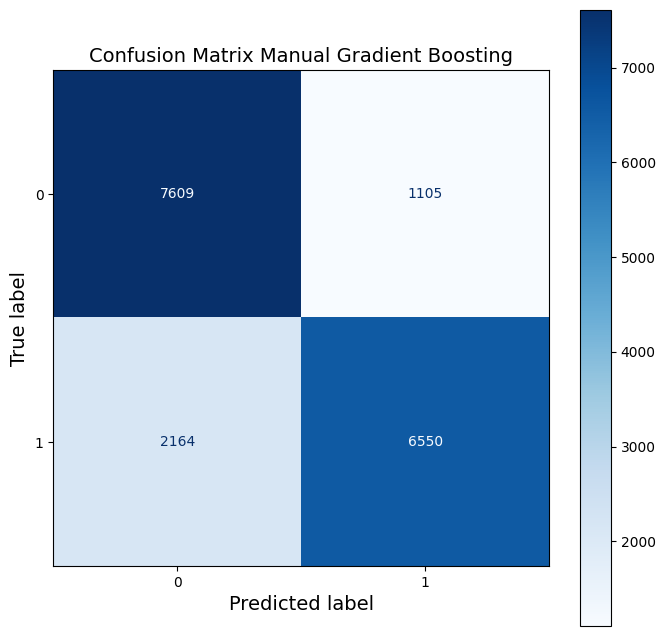


 ROC Curves:


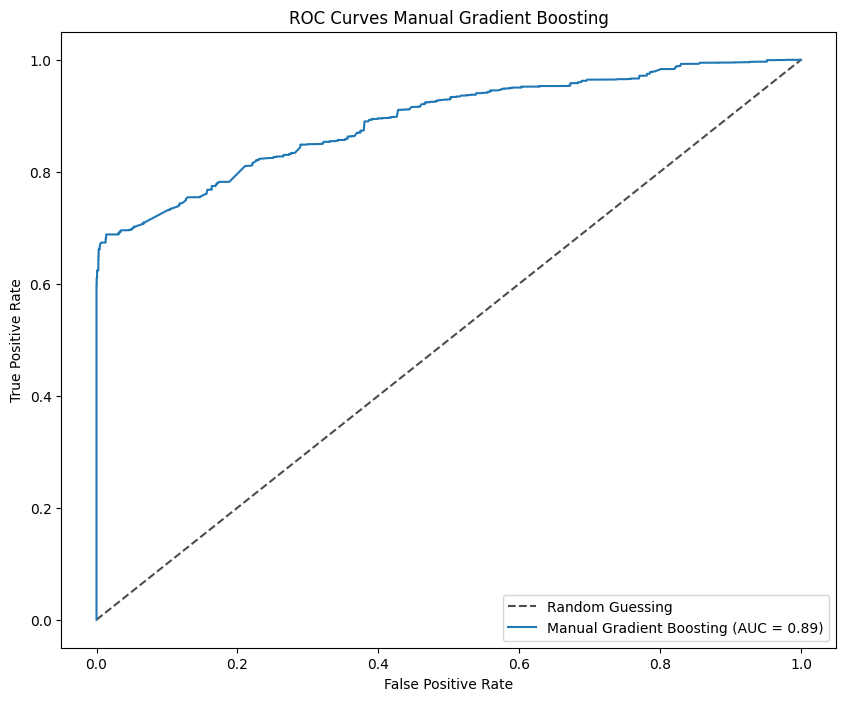

In [ ]:
manual_gradient_model = ManualGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
manual_gradient_model.fit(X_train_smoted, y_train_smoted)
y_pred_manual_gradient = manual_gradient_model.predict(X_test_smoted)
y_pred_prod_gradient = manual_gradient_model.predict_proba(X_test_smoted)

print("\n--- Evaluation of Manual Gradient Boosting Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_gradient))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual Gradient Boosting", y_pred_manual_gradient, y_test_smoted, "7:3")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual Gradient Boosting', 'radio': '7:3'}], y_test_smoted, y_pred_prod_gradient)


--- Evaluation of RBF SVM Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      8714
           1       0.88      0.80      0.84      8714

    accuracy                           0.84     17428
   macro avg       0.85      0.84      0.84     17428
weighted avg       0.85      0.84      0.84     17428


Confusion Matrix:


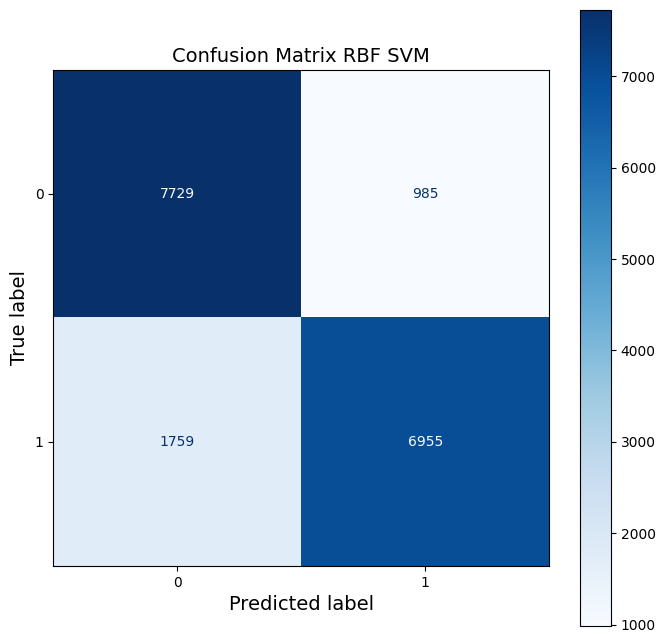


 ROC Curves:


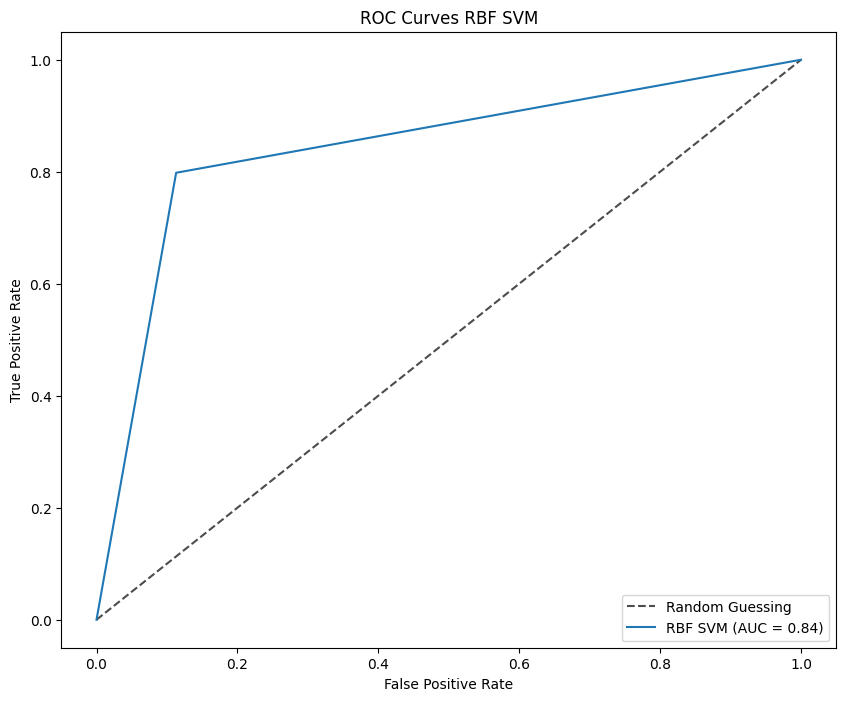

In [ ]:
svc_model = RBF_SVC(C=10.0, gamma='scale')
svc_model.fit(X_train_smoted, y_train_smoted)
y_pred_svc = svc_model.predict(X_test_smoted)

print("\n--- Evaluation of RBF SVM Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_svc))
print("\nConfusion Matrix:")
print_confusion_matrix("RBF SVM", y_pred_svc, y_test_smoted, "7:3")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'RBF SVM', 'radio': '7:3'}], y_test_smoted, y_pred_svc)

## 5.3. Huấn luyện mô hình với tập train/test tỉ lệ 6/4

In [ ]:
# Re-split the data to ensure fresh start for this cell
X_train_raw, y_train_raw, X_test_raw, y_test_raw = data_split(data, test_size=0.4)

# Preprocess the data using the defined preprocessor
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

# Apply SMOTE oversampling to the training data, correctly assigning outputs
X_train_smoted, y_train_smoted = SMOTE_oversample(X_train_processed, y_train_raw)
X_test_smoted, y_test_smoted = SMOTE_oversample(X_test_processed, y_test_raw)

Epoch 10/300, Log Loss: 0.2081
Epoch 20/300, Log Loss: 0.1764
Epoch 30/300, Log Loss: 0.1570
Epoch 40/300, Log Loss: 0.1270
Epoch 50/300, Log Loss: 0.1343
Epoch 60/300, Log Loss: 0.1367
Epoch 70/300, Log Loss: 0.1044
Epoch 80/300, Log Loss: 0.1031
Epoch 90/300, Log Loss: 0.0902
Epoch 100/300, Log Loss: 0.0895
Epoch 110/300, Log Loss: 0.0924
Epoch 120/300, Log Loss: 0.0814
Epoch 130/300, Log Loss: 0.0910
Epoch 140/300, Log Loss: 0.0832
Epoch 150/300, Log Loss: 0.0787
Epoch 160/300, Log Loss: 0.0776
Epoch 170/300, Log Loss: 0.0769
Epoch 180/300, Log Loss: 0.0756
Epoch 190/300, Log Loss: 0.0750
Epoch 200/300, Log Loss: 0.0841
Epoch 210/300, Log Loss: 0.0754
Epoch 220/300, Log Loss: 0.0684
Epoch 230/300, Log Loss: 0.0706
Epoch 240/300, Log Loss: 0.0676
Epoch 250/300, Log Loss: 0.0686
Epoch 260/300, Log Loss: 0.0690
Epoch 270/300, Log Loss: 0.0624
Epoch 280/300, Log Loss: 0.0782
Epoch 290/300, Log Loss: 0.0878
Epoch 300/300, Log Loss: 0.0615

--- Evaluation of Manual MLP Model ---
Classific

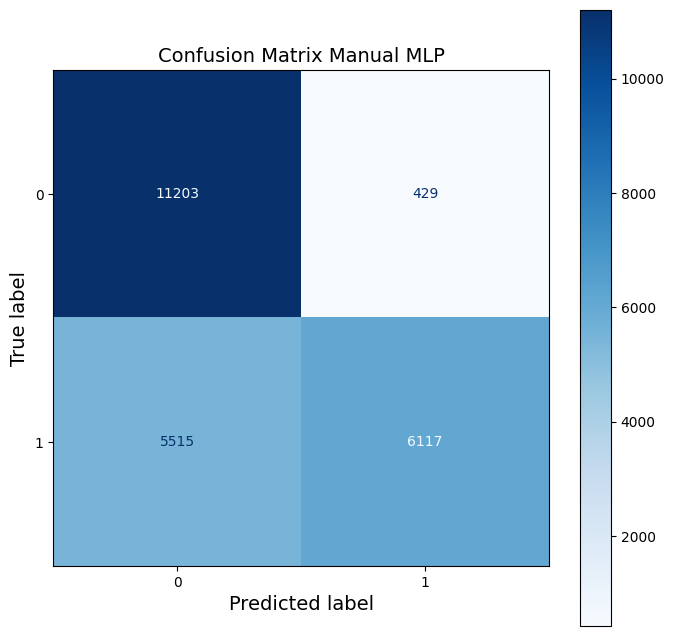


 ROC Curves:


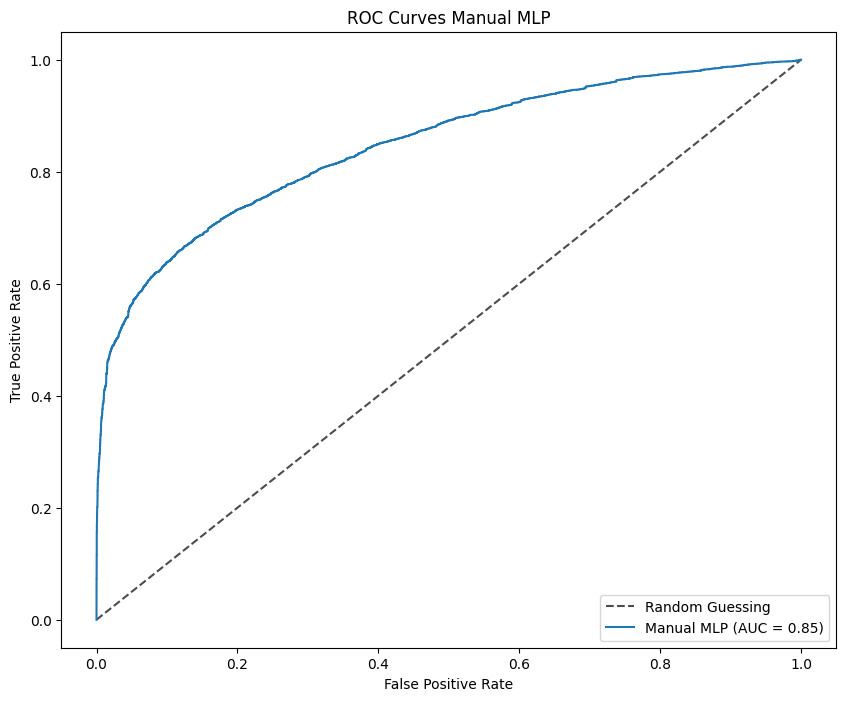

In [ ]:
# Initialize and train the manual MLP model
mlp_manual_model = ManualMLP(input_size=X_train_smoted.shape[1],
                                      hidden_size=256, # Increased hidden_size from 128 to 256
                                      output_size=1,
                                      learning_rate=0.005) # You can adjust learning_rate

mlp_manual_model.fit(X_train_smoted, y_train_smoted.values, epochs=300, batch_size=32)

# Predict on the test set
y_pred_manual_mlp = mlp_manual_model.predict(X_test_smoted)
y_pred_prob_mlp = mlp_manual_model.predict_proba(X_test_smoted)

# Evaluate the model
print("\n--- Evaluation of Manual MLP Model ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_mlp))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual MLP", y_pred_manual_mlp, y_test_smoted, "6:4")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual MLP', 'radio': '6:4'}], y_test_smoted, y_pred_prob_mlp)


--- Evaluation of Manual Gradient Boosting Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.96      0.85     11632
           1       0.94      0.70      0.80     11632

    accuracy                           0.83     23264
   macro avg       0.85      0.83      0.82     23264
weighted avg       0.85      0.83      0.82     23264


Confusion Matrix:


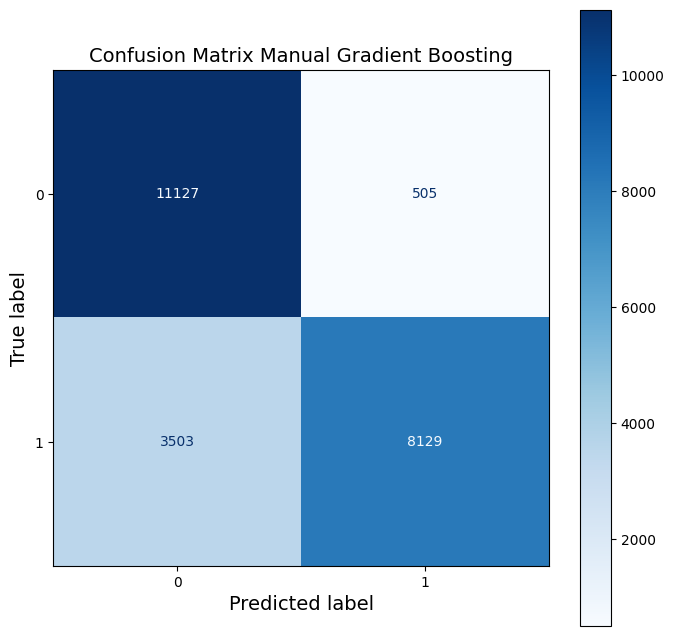


 ROC Curves:


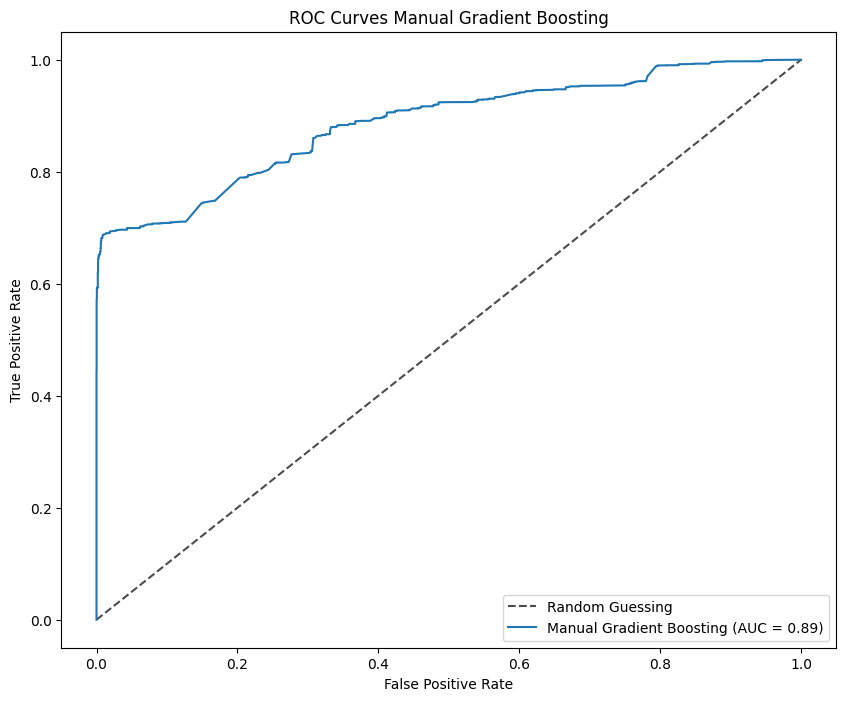

In [ ]:
manual_gradient_model = ManualGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
manual_gradient_model.fit(X_train_smoted, y_train_smoted)

y_pred_manual_gradient = manual_gradient_model.predict(X_test_smoted)
y_pred_prob_gradient = manual_gradient_model.predict_proba(X_test_smoted)

print("\n--- Evaluation of Manual Gradient Boosting Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_gradient))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual Gradient Boosting", y_pred_manual_gradient, y_test_smoted, "6:4")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual Gradient Boosting', 'radio': '6:4'}], y_test_smoted, y_pred_prob_gradient)


--- Evaluation of RBF SVM Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82     11632
           1       0.86      0.72      0.79     11632

    accuracy                           0.81     23264
   macro avg       0.81      0.81      0.80     23264
weighted avg       0.81      0.81      0.80     23264


Confusion Matrix:


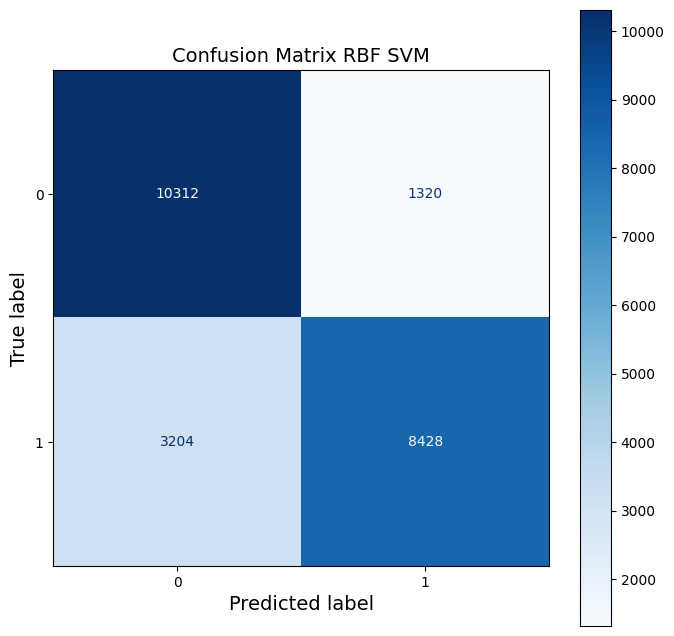


 ROC Curves:


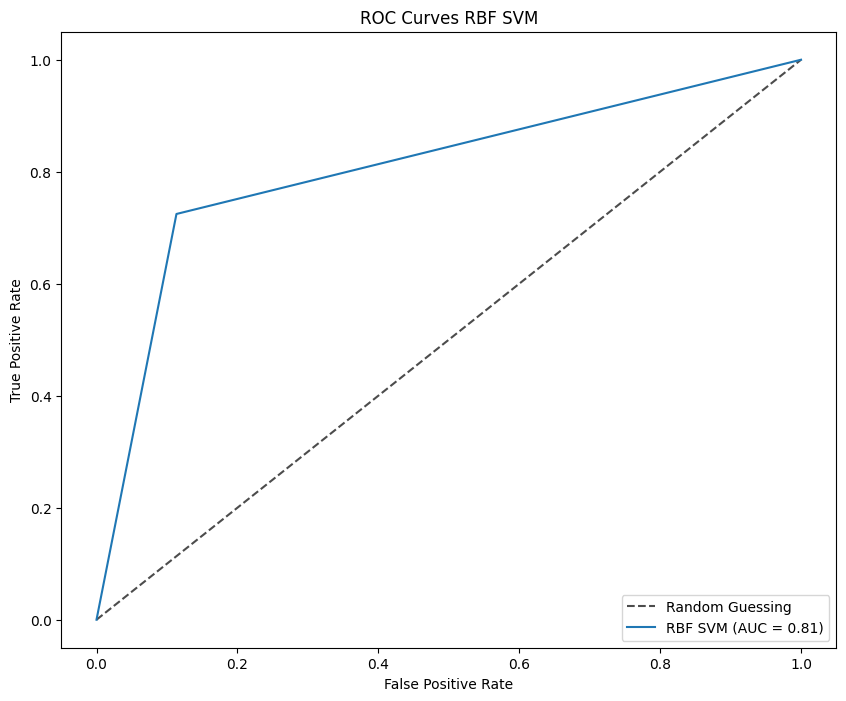

In [ ]:
svc_model = RBF_SVC(C=10.0, gamma='scale')
svc_model.fit(X_train_smoted, y_train_smoted)
y_pred_svc = svc_model.predict(X_test_smoted)

print("\n--- Evaluation of RBF SVM Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_svc))
print("\nConfusion Matrix:")
print_confusion_matrix("RBF SVM", y_pred_svc, y_test_smoted, "6:4")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'RBF SVM', 'radio': '6:4'}], y_test_smoted, y_pred_svc)

## 5.4. Huấn luyện mô hình với dữ liệu giảm chiều PCA

In [ ]:
X_train, y_train, X_test, y_test = data_split(data, test_size=0.2)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_smoted, y_train_smoted = SMOTE_oversample(X_train_processed, y_train)
X_test_smoted, y_test_smoted = SMOTE_oversample(X_test_processed, y_test)

pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train_smoted)
X_test_pca = pca.transform(X_test_smoted)

Epoch 10/300, Log Loss: 0.3438
Epoch 20/300, Log Loss: 0.3289
Epoch 30/300, Log Loss: 0.2981
Epoch 40/300, Log Loss: 0.3029
Epoch 50/300, Log Loss: 0.3098
Epoch 60/300, Log Loss: 0.2970
Epoch 70/300, Log Loss: 0.2595
Epoch 80/300, Log Loss: 0.2827
Epoch 90/300, Log Loss: 0.2629
Epoch 100/300, Log Loss: 0.2657
Epoch 110/300, Log Loss: 0.2720
Epoch 120/300, Log Loss: 0.2808
Epoch 130/300, Log Loss: 0.2664
Epoch 140/300, Log Loss: 0.2604
Epoch 150/300, Log Loss: 0.2482
Epoch 160/300, Log Loss: 0.2481
Epoch 170/300, Log Loss: 0.2669
Epoch 180/300, Log Loss: 0.2457
Epoch 190/300, Log Loss: 0.2514
Epoch 200/300, Log Loss: 0.2533
Epoch 210/300, Log Loss: 0.2542
Epoch 220/300, Log Loss: 0.2689
Epoch 230/300, Log Loss: 0.2679
Epoch 240/300, Log Loss: 0.2344
Epoch 250/300, Log Loss: 0.2621
Epoch 260/300, Log Loss: 0.2298
Epoch 270/300, Log Loss: 0.2548
Epoch 280/300, Log Loss: 0.2336
Epoch 290/300, Log Loss: 0.2289
Epoch 300/300, Log Loss: 0.2442

--- Evaluation of Manual MLP Model ---
Classific

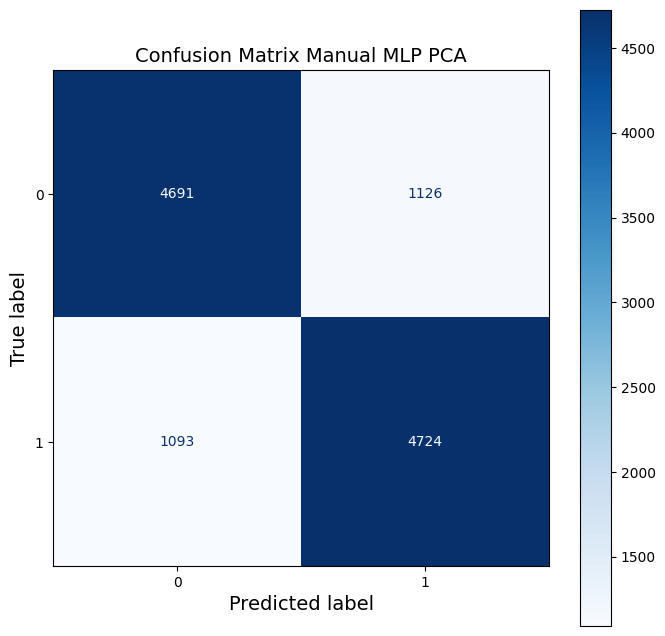


 ROC Curves:


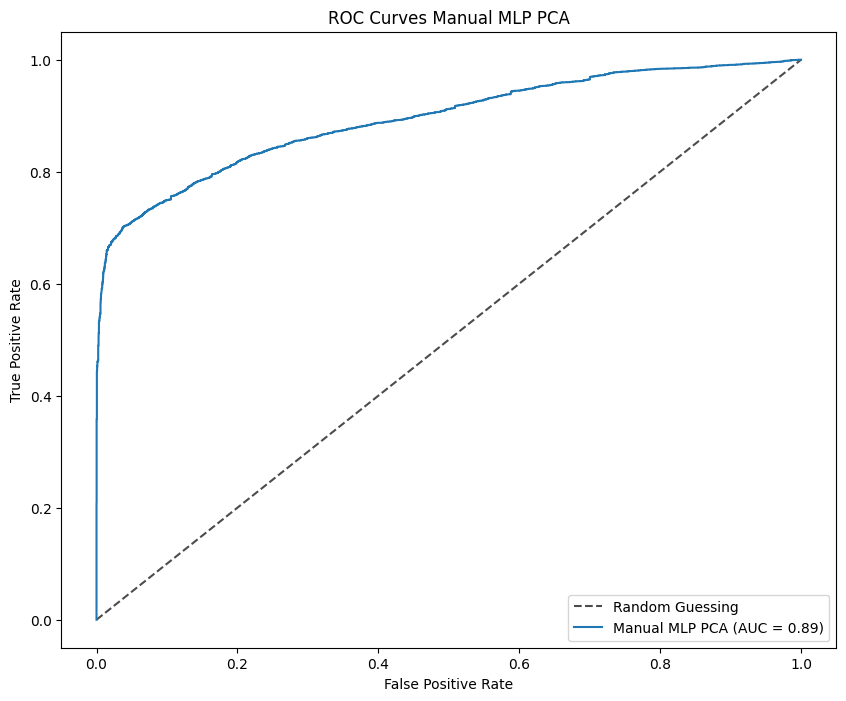

In [ ]:
# Initialize and train the manual MLP model
mlp_manual_model = ManualMLP(input_size=X_train_pca.shape[1],
                                      hidden_size=256, # Increased hidden_size from 128 to 256
                                      output_size=1,
                                      learning_rate=0.005) # You can adjust learning_rate

mlp_manual_model.fit(X_train_pca, y_train_smoted.values, epochs=300, batch_size=32)

# Predict on the test set
y_pred_manual_mlp = mlp_manual_model.predict(X_test_pca)
y_pred_prob_mlp = mlp_manual_model.predict_proba(X_test_pca)

# Evaluate the model
print("\n--- Evaluation of Manual MLP Model ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_mlp))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual MLP PCA", y_pred_manual_mlp, y_test_smoted, "8:2")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual MLP PCA', 'radio': '8:2'}], y_test_smoted, y_pred_prob_mlp.flatten())


--- Evaluation of Manual Gradient Boosting Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.64      5817
           1       0.65      0.77      0.70      5817

    accuracy                           0.67     11634
   macro avg       0.68      0.67      0.67     11634
weighted avg       0.68      0.67      0.67     11634


Confusion Matrix:


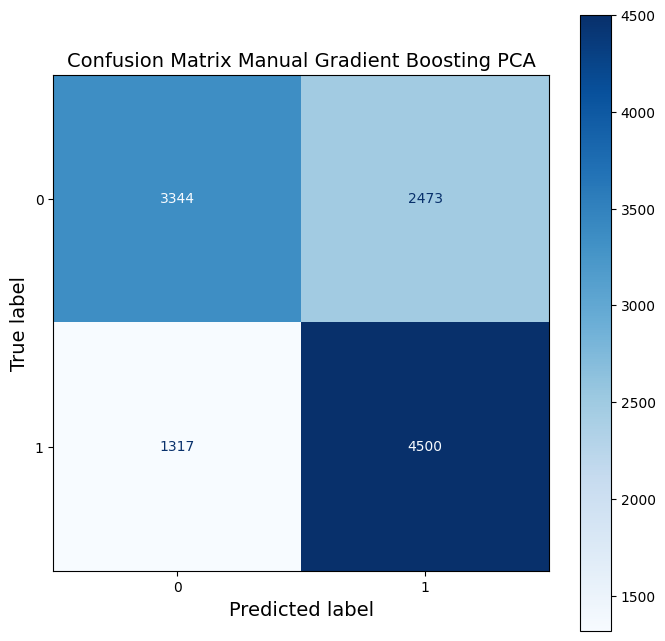


 ROC Curves:


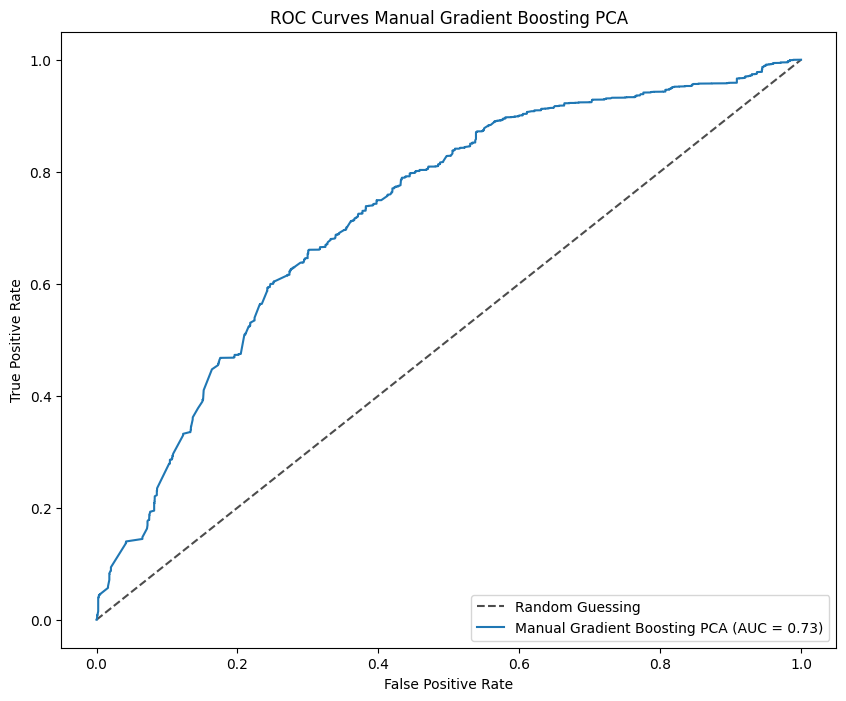

In [ ]:
manual_gradient_model = ManualGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
manual_gradient_model.fit(X_train_pca, y_train_smoted)

y_pred_manual_gradient = manual_gradient_model.predict(X_test_pca)
y_pred_prob_gradient = manual_gradient_model.predict_proba(X_test_pca)

print("\n--- Evaluation of Manual Gradient Boosting Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_gradient))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual Gradient Boosting PCA", y_pred_manual_gradient, y_test_smoted, "8:2")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual Gradient Boosting PCA', 'radio': '8:2'}], y_test_smoted, y_pred_prob_gradient)


--- Evaluation of RBF SVM Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      5817
           1       0.82      0.81      0.82      5817

    accuracy                           0.82     11634
   macro avg       0.82      0.82      0.82     11634
weighted avg       0.82      0.82      0.82     11634


Confusion Matrix:


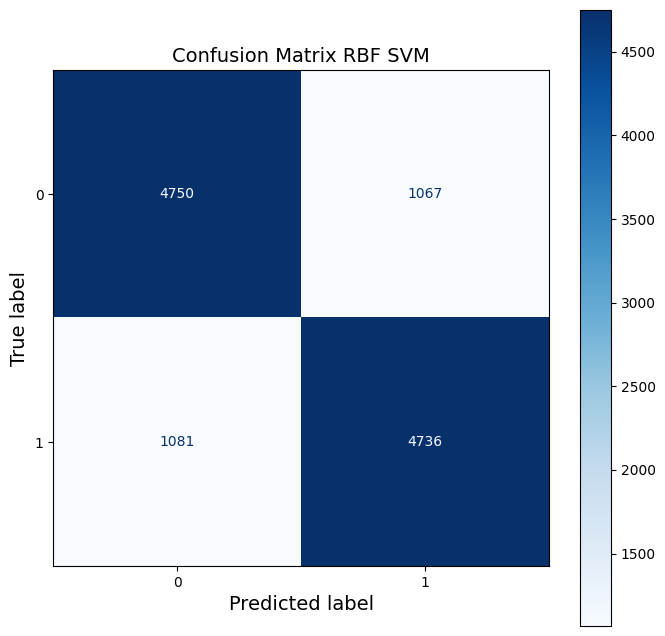


 ROC Curves:


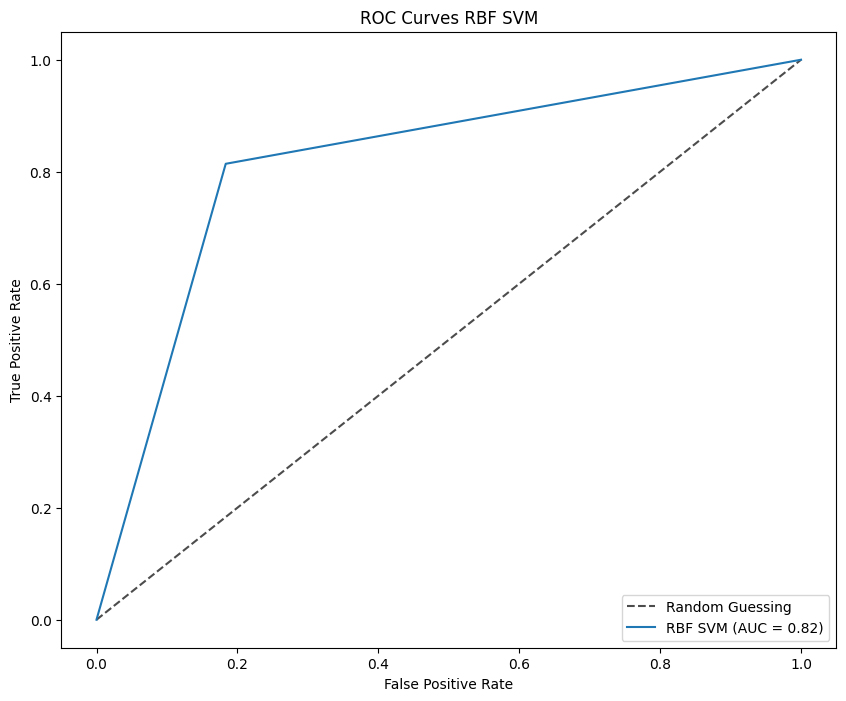

In [ ]:
svc_model = RBF_SVC(C=10.0, gamma='scale')
svc_model.fit(X_train_pca, y_train_smoted)
y_pred_svc = svc_model.predict(X_test_pca)

print("\n--- Evaluation of RBF SVM Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_svc))
print("\nConfusion Matrix:")
print_confusion_matrix("RBF SVM LDA", y_pred_svc, y_test_smoted, "8:2")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'RBF SVM LDA', 'radio': '8:2'}], y_test_smoted, y_pred_svc)

## 5.5. Huấn luyện mô hình với dữ liệu giảm chiều LDA

In [ ]:
X_train, y_train, X_test, y_test = data_split(data, test_size=0.2)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_smoted, y_train_smoted = SMOTE_oversample(X_train_processed, y_train)
X_test_smoted, y_test_smoted = SMOTE_oversample(X_test_processed, y_test)

lda = LinearDiscriminantAnalysis(n_components=1) # Changed n_components to 1
X_train_lda = lda.fit_transform(X_train_smoted, y_train_smoted)
X_test_lda = lda.transform(X_test_smoted)

Epoch 10/300, Log Loss: 0.6561
Epoch 20/300, Log Loss: 0.6570
Epoch 30/300, Log Loss: 0.6573
Epoch 40/300, Log Loss: 0.6532
Epoch 50/300, Log Loss: 0.6543
Epoch 60/300, Log Loss: 0.6527
Epoch 70/300, Log Loss: 0.6523
Epoch 80/300, Log Loss: 0.6523
Epoch 90/300, Log Loss: 0.6533
Epoch 100/300, Log Loss: 0.6527
Epoch 110/300, Log Loss: 0.6522
Epoch 120/300, Log Loss: 0.6537
Epoch 130/300, Log Loss: 0.6527
Epoch 140/300, Log Loss: 0.6521
Epoch 150/300, Log Loss: 0.6522
Epoch 160/300, Log Loss: 0.6531
Epoch 170/300, Log Loss: 0.6522
Epoch 180/300, Log Loss: 0.6529
Epoch 190/300, Log Loss: 0.6546
Epoch 200/300, Log Loss: 0.6522
Epoch 210/300, Log Loss: 0.6527
Epoch 220/300, Log Loss: 0.6534
Epoch 230/300, Log Loss: 0.6523
Epoch 240/300, Log Loss: 0.6527
Epoch 250/300, Log Loss: 0.6524
Epoch 260/300, Log Loss: 0.6521
Epoch 270/300, Log Loss: 0.6529
Epoch 280/300, Log Loss: 0.6519
Epoch 290/300, Log Loss: 0.6521
Epoch 300/300, Log Loss: 0.6530

--- Evaluation of Manual MLP Model ---
Classific

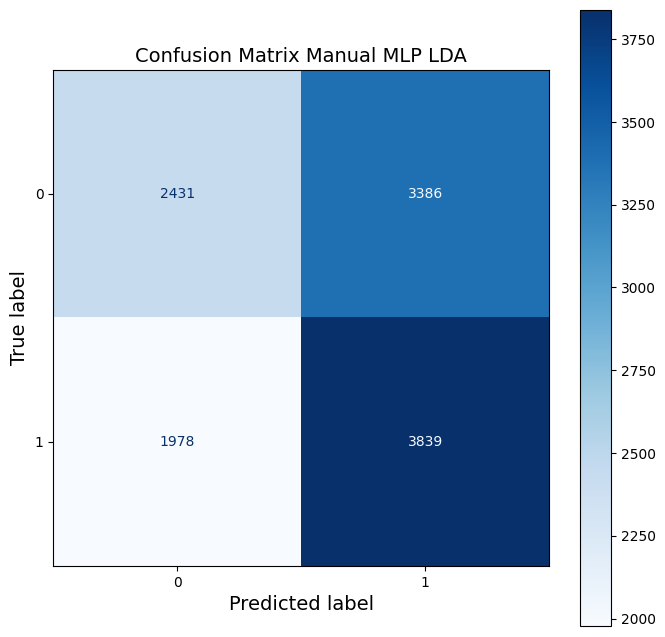


 ROC Curves:


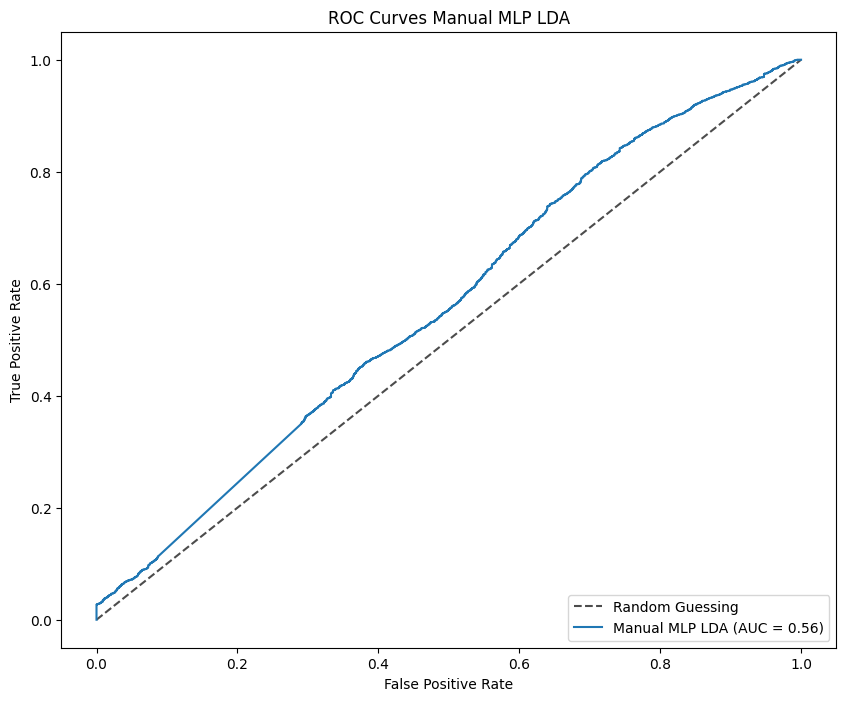

In [ ]:
# Initialize and train the manual MLP model
mlp_manual_model = ManualMLP(input_size=X_train_lda.shape[1],
                                      hidden_size=256, # Increased hidden_size from 128 to 256
                                      output_size=1,
                                      learning_rate=0.005) # You can adjust learning_rate

mlp_manual_model.fit(X_train_lda, y_train_smoted.values, epochs=300, batch_size=32)

# Predict on the test set
y_pred_manual_mlp = mlp_manual_model.predict(X_test_lda)
y_pred_prob_mlp = mlp_manual_model.predict_proba(X_test_lda)

# Evaluate the model
print("\n--- Evaluation of Manual MLP Model ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_mlp))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual MLP LDA", y_pred_manual_mlp, y_test_smoted, "8:2")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual MLP LDA', 'radio': '8:2'}], y_test_smoted, y_pred_prob_mlp.flatten())


--- Evaluation of Manual Gradient Boosting Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.35      0.44      5817
           1       0.54      0.76      0.63      5817

    accuracy                           0.56     11634
   macro avg       0.57      0.56      0.54     11634
weighted avg       0.57      0.56      0.54     11634


Confusion Matrix:


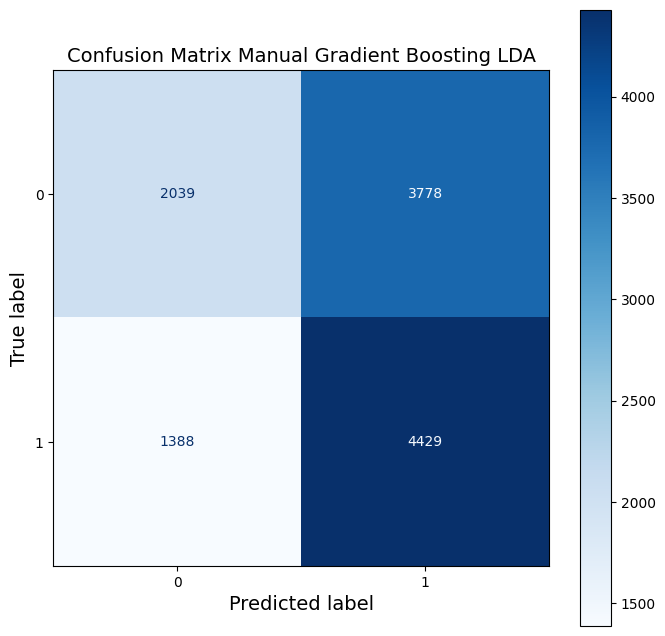


 ROC Curves:


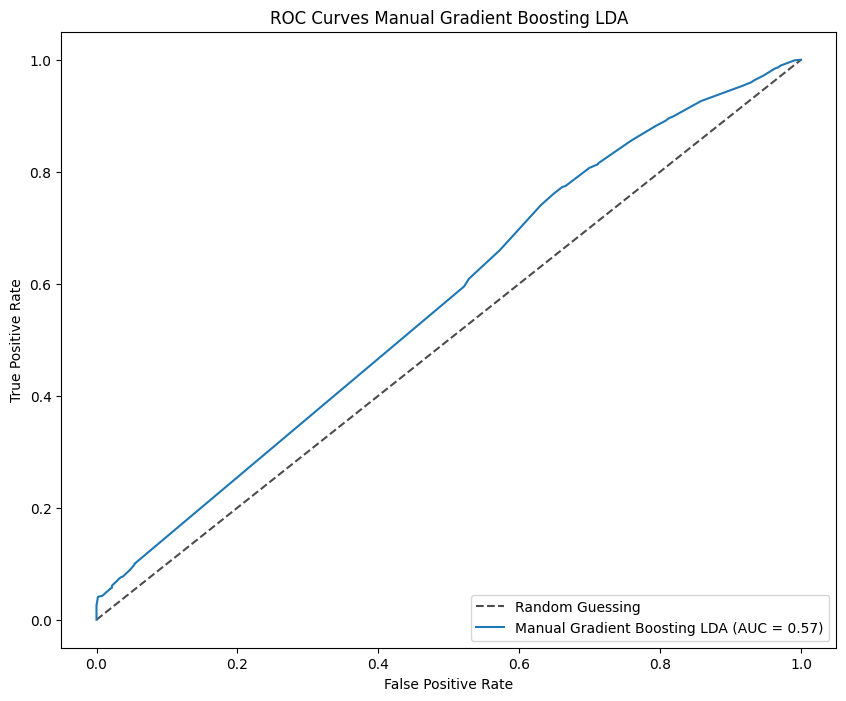

In [ ]:
manual_gradient_model = ManualGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
manual_gradient_model.fit(X_train_lda, y_train_smoted)

y_pred_manual_gradient = manual_gradient_model.predict(X_test_lda)
y_pred_prob_gradient = manual_gradient_model.predict_proba(X_test_lda)

print("\n--- Evaluation of Manual Gradient Boosting Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_manual_gradient))
print("\nConfusion Matrix:")
print_confusion_matrix("Manual Gradient Boosting LDA", y_pred_manual_gradient, y_test_smoted, "8:2")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'Manual Gradient Boosting LDA', 'radio': '8:2'}], y_test_smoted, y_pred_prob_gradient)


--- Evaluation of RBF SVM Classifier ---
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.33      0.42      5817
           1       0.54      0.78      0.63      5817

    accuracy                           0.55     11634
   macro avg       0.57      0.55      0.53     11634
weighted avg       0.57      0.55      0.53     11634


Confusion Matrix:


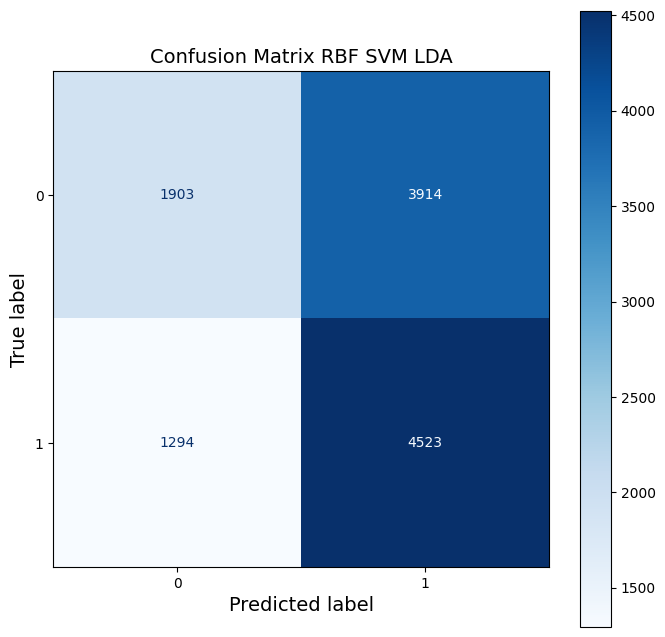


 ROC Curves:


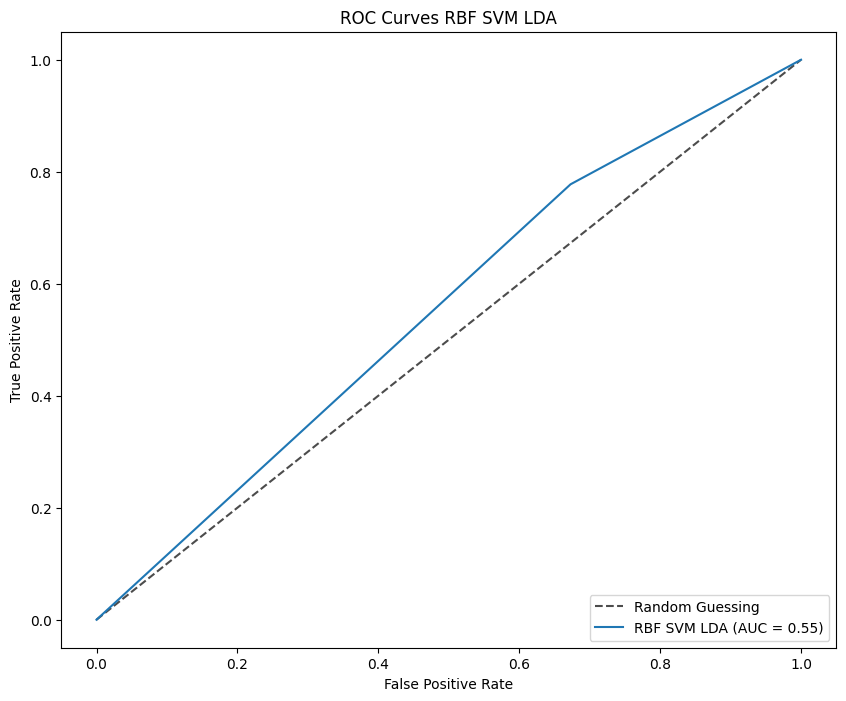

In [ ]:
svc_model = RBF_SVC(C=10.0, gamma='scale')
svc_model.fit(X_train_lda, y_train_smoted)
y_pred_svc = svc_model.predict(X_test_lda)

print("\n--- Evaluation of RBF SVM Classifier ---")
print("Classification Report:")
print(classification_report(y_test_smoted, y_pred_svc))
print("\nConfusion Matrix:")
print_confusion_matrix("RBF SVM LDA", y_pred_svc, y_test_smoted, "8:2")
print("\n ROC Curves:")
plot_roc_curves_binary([{'name': 'RBF SVM LDA', 'radio': '8:2'}], y_test_smoted, y_pred_svc)

# Chuẩn từ Phân loại sang Hồi quy

In [ ]:
def plot_regression_comparison(results_dict, title="So sánh mô hình hồi quy"):

    n_models = len(results_dict)
    fig, axes = plt.subplots(n_models, 6, figsize=(24, 4*n_models))

    if n_models == 1:
        axes = axes.reshape(1, -1)
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

    for idx, (model_name, results) in enumerate(results_dict.items()):
        y_test = results["y_test"]
        y_pred = results["y_pred"]
        residuals = y_test - y_pred

        color = colors[idx % len(colors)]

        # 1. Dự đoán vs Thực tế
        axes[idx, 0].scatter(y_test, y_pred, alpha=0.6, color=color, s=30)
        axes[idx, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                         'r--', lw=2)
        axes[idx, 0].set_xlabel('Giá trị thực')
        axes[idx, 0].set_ylabel('Dự đoán')
        axes[idx, 0].set_title(f'{model_name}\nDự đoán vs Thực tế')
        axes[idx, 0].grid(True, alpha=0.3)

        # 2. Phân bố phần dư
        axes[idx, 1].hist(residuals, bins=30, alpha=0.7, color=color, edgecolor='black')
        axes[idx, 1].axvline(0, color='red', linestyle='--', lw=2)
        axes[idx, 1].set_xlabel('Phần dư')
        axes[idx, 1].set_ylabel('Tần số')
        axes[idx, 1].set_title('Phân bố phần dư')
        axes[idx, 1].grid(True, alpha=0.3)

        # 3. Phần dư vs Dự đoán
        axes[idx, 2].scatter(y_pred, residuals, alpha=0.6, color=color, s=30)
        axes[idx, 2].axhline(0, color='red', linestyle='--', lw=2)
        axes[idx, 2].set_xlabel('Dự đoán')
        axes[idx, 2].set_ylabel('Phần dư')
        axes[idx, 2].set_title('Phần dư vs Dự đoán')
        axes[idx, 2].grid(True, alpha=0.3)

        # 4. QQ Plot
        stats.probplot(residuals, dist="norm", plot=axes[idx, 3])
        axes[idx, 3].set_title('QQ Plot - Kiểm tra chuẩn')
        axes[idx, 3].grid(True, alpha=0.3)

        # 5. Phần dư theo trình tự
        axes[idx, 4].plot(residuals, 'o-', alpha=0.6, color=color, markersize=4)
        axes[idx, 4].axhline(0, color='red', linestyle='--', lw=2)
        axes[idx, 4].set_xlabel('Index (trình tự)')
        axes[idx, 4].set_ylabel('Phần dư')
        axes[idx, 4].set_title('Phần dư theo trình tự')
        axes[idx, 4].grid(True, alpha=0.3)

        # 6. Boxplot phần dư
        bp = axes[idx, 5].boxplot(residuals, patch_artist=True)
        bp['boxes'][0].set_facecolor(color)
        bp['boxes'][0].set_alpha(0.7)
        axes[idx, 5].axhline(0, color='red', linestyle='--', lw=2)
        axes[idx, 5].set_ylabel('Phần dư')
        axes[idx, 5].set_title('Boxplot phần dư')
        axes[idx, 5].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f"image/{title}.png", dpi = 300, bbox_inches = 'tight')
    plt.show()

In [ ]:
def create_regression_targets(X_train, X_test, y_train, use_decision_function=True):
    from sklearn.linear_model import LogisticRegression

    logreg = LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver='lbfgs'
    )

    logreg.fit(X_train, y_train)

    if use_decision_function and hasattr(logreg, 'decision_function'):
        y_train_reg = logreg.decision_function(X_train)
        y_test_reg = logreg.decision_function(X_test)
    else:
        y_train_reg = logreg.predict_proba(X_train)[:, 1]
        y_test_reg = logreg.predict_proba(X_test)[:, 1]

    return y_train_reg, y_test_reg

### XgBoost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def train_xgboost(X_train, y_train, X_test, y_test):
    model = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return y_test, y_pred, mse, r2

In [ ]:
ratios = {'7:3': 0.3, '4:1': 0.2, '6:4': 0.4}
results_original = {}
for ratio_name, test_size in ratios.items():
    print(f"\n--- Tỷ lệ {ratio_name} ---")
    X_train, y_train, X_test, y_test = data_split(data, test_size=test_size)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    y_train_reg, y_test_reg = create_regression_targets(X_train_processed, X_test_processed, y_train)

    # Corrected line: Pass X_train_processed and X_test_processed to train_xgboost
    y_test_prob, y_pred_prob, mse, r2 = train_xgboost(X_train_processed, y_train_reg, X_test_processed, y_test_reg)


    print(f"MSE: {mse}, R²: {r2:.6f}")


--- Tỷ lệ 7:3 ---
MSE: 0.003362791431844386, R²: 0.976857

--- Tỷ lệ 4:1 ---
MSE: 0.0007123994475765963, R²: 0.994011

--- Tỷ lệ 6:4 ---
MSE: 0.004720819133679635, R²: 0.972620


In [ ]:
results_pca = {}
for ratio_name, test_size in ratios.items():
    print(f"\n--- Tỷ lệ {ratio_name} ---")
    X_train, y_train, X_test, y_test = data_split(data, test_size=test_size)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    y_train_logit, y_test_logit = create_regression_targets(X_train_processed, X_test_processed, y_train)

    # PCA
    n_components = max(1, X_train_processed.shape[1] // 3)
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_processed)
    X_test_pca = pca.transform(X_test_processed)

    y_test_prob_pca, y_pred_prob_pca, mse, r2 = train_xgboost(X_train_pca, y_train_logit, X_test_pca, y_test_logit)

    print(f"MSE: {mse:.6f}, R²: {r2:.6f}")


--- Tỷ lệ 7:3 ---
MSE: 0.055867, R²: 0.615523

--- Tỷ lệ 4:1 ---
MSE: 0.039522, R²: 0.667743

--- Tỷ lệ 6:4 ---
MSE: 0.048406, R²: 0.719252


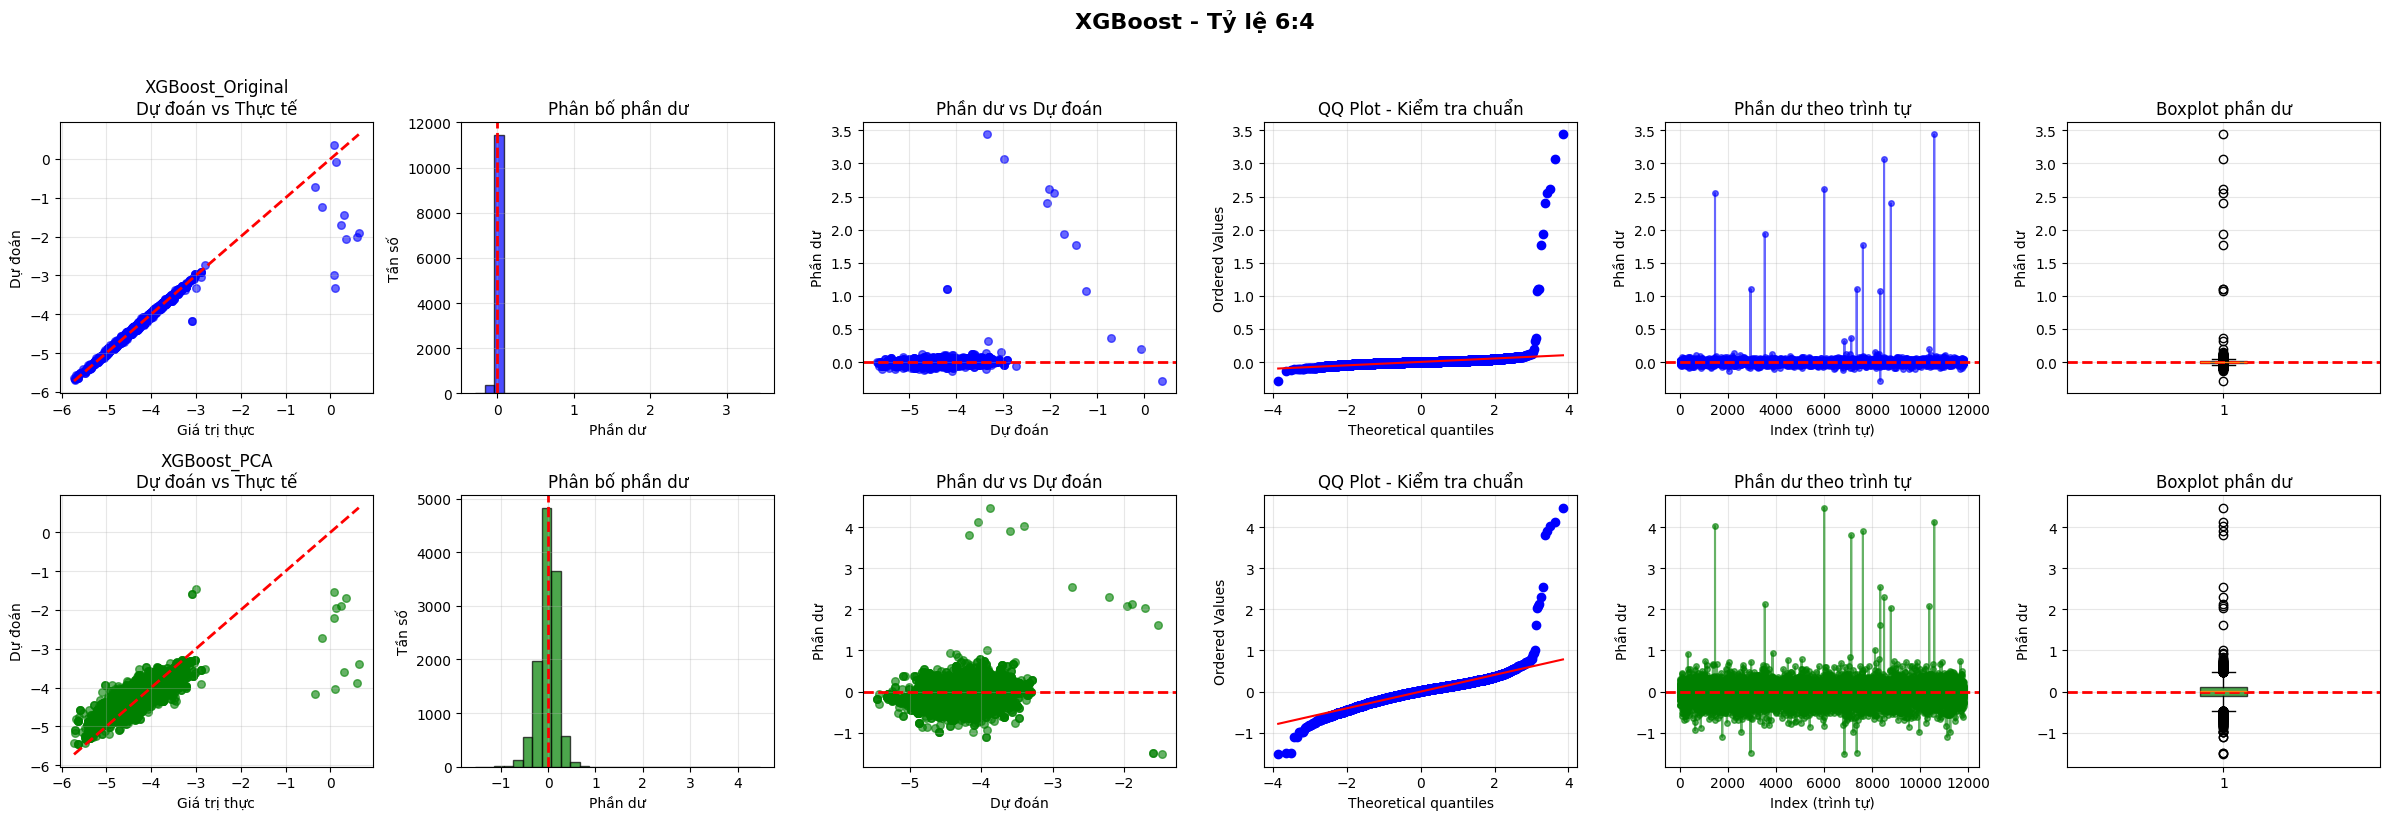

In [ ]:
results = {
    "XGBoost_Original": {
        "y_test": y_test_prob,
        "y_pred": y_pred_prob
    },
    "XGBoost_PCA": {
        "y_test": y_test_prob_pca,
        "y_pred": y_pred_prob_pca
    }
}

plot_regression_comparison(
    results,
    title="XGBoost - Tỷ lệ 6:4"
)

### Ramdom Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def train_random_forest(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        max_features="sqrt",
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return y_test, y_pred, mse, r2


In [ ]:
ratios = {'7:3': 0.3, '4:1': 0.2, '6:4': 0.4}
results_original = {}

for ratio_name, test_size in ratios.items():
    print(f"\n--- Tỷ lệ {ratio_name} ---")

    X_train, y_train, X_test, y_test = data_split(data, test_size=test_size)

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    y_train_reg, y_test_reg = create_regression_targets(
        X_train_processed, X_test_processed, y_train
    )

    # Random Forest
    y_test_rf, y_pred_rf, mse, r2 = train_random_forest(
        X_train_processed,
        y_train_reg,
        X_test_processed,
        y_test_reg
    )

    print(f"MSE: {mse}, R²: {r2:.6f}")



--- Tỷ lệ 7:3 ---
MSE: 0.022387351548296044, R²: 0.845929

--- Tỷ lệ 4:1 ---
MSE: 0.014609518304408422, R²: 0.877181

--- Tỷ lệ 6:4 ---
MSE: 0.021946998288508095, R²: 0.872710


In [ ]:
results_pca = {}

for ratio_name, test_size in ratios.items():
    print(f"\n--- Tỷ lệ {ratio_name} ---")

    X_train, y_train, X_test, y_test = data_split(data, test_size=test_size)

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    y_train_reg, y_test_reg = create_regression_targets(
        X_train_processed, X_test_processed, y_train
    )

    # PCA
    n_components = max(1, X_train_processed.shape[1] // 3)
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train_processed)
    X_test_pca = pca.transform(X_test_processed)

    # Random Forest
    y_test_rf_pca, y_pred_rf_pca, mse, r2 = train_random_forest(
        X_train_pca,
        y_train_reg,
        X_test_pca,
        y_test_reg
    )

    print(f"MSE: {mse:.6f}, R²: {r2:.6f}")



--- Tỷ lệ 7:3 ---
MSE: 0.045462, R²: 0.687127

--- Tỷ lệ 4:1 ---
MSE: 0.034032, R²: 0.713901

--- Tỷ lệ 6:4 ---
MSE: 0.046771, R²: 0.728734


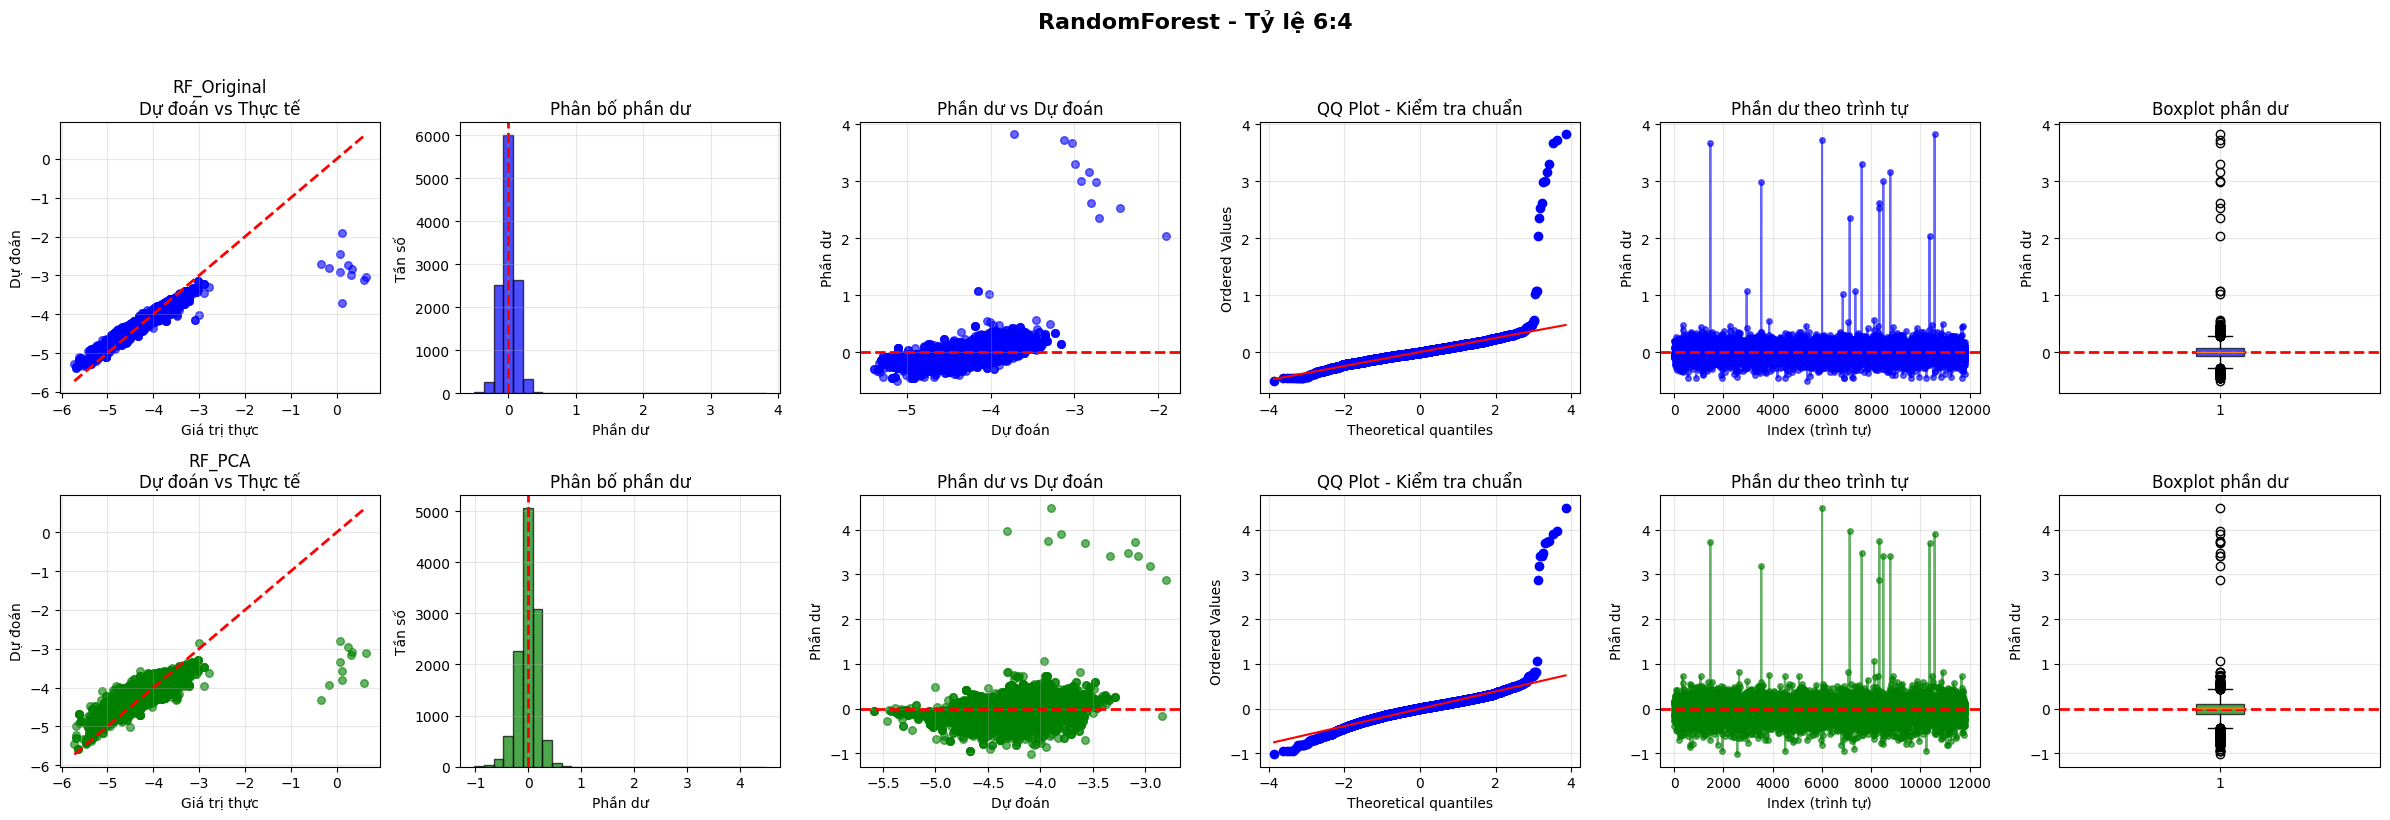

In [ ]:
results = {
    "RF_Original": {
        "y_test": y_test_rf,
        "y_pred": y_pred_rf
    },
    "RF_PCA": {
        "y_test": y_test_rf_pca,
        "y_pred": y_pred_rf_pca
    }
}

plot_regression_comparison(
    results,
    title="RandomForest - Tỷ lệ 6:4"
)